In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import anndata as ad
from cyvcf2 import VCF
from tqdm import tqdm
from scipy import stats
from functools import partial

# Loading data

Expression data:

In [2]:
file = '/home/e860a/chernova/onek1k/norm/onek1k.norm_pflogpf.h5ad'

In [3]:
data = ad.read_h5ad(file)

eQTL data:

In [5]:
eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

# Plotting functions
## Violinplots

In [25]:
def plot_by_gene(gene, snp_idx, delete_zeros = False, exponential=False, savefig=None):
    mask = eqtl.loc[snp_idx, 'Gene Ensembl ID']==gene
    unique_snps = np.unique(eqtl.loc[snp_idx, 'SNP'][mask], return_counts=True)

    rows = unique_snps[1].shape[0]
    columns = np.max(unique_snps[1])
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(3*columns, 3*rows)

    colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']

    for ax_y, u_snp in enumerate(unique_snps[0]):
        mask = eqtl.loc[snp_idx, 'SNP'] == u_snp
        subset = eqtl.loc[snp_idx, :][mask]
        for ax_x, i in enumerate(subset.index.values):
            snp = eqtl.index.values[i]
            if eqtl.loc[snp, 'Gene Ensembl ID'] != gene:
                continue
            expr_list = []
            class_list = []
            for col in range(3):
                search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
                if type(search_str)==str:
                    search_str = search_str.replace(',', '|') # Transform to regex

                    #gene = eqtl.loc[snp, 'Gene Ensembl ID']
                    cell_type = eqtl.loc[snp, 'Cell type']

                    mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                          data.obs['old_cell_label']==cell_type)

                    x = data[mask, gene].to_df().to_numpy()
                    
                    if delete_zeros:
                        if np.sum(x==0)<x.shape[0]:
                            x = x[x!=0]
                    
                    expr_list.append(x.flatten())
                    class_list.extend([colnames[col] for i in range(x.shape[0])])

            gene_name = eqtl.loc[snp, 'Gene ID']
            cell_name = eqtl.loc[snp, 'Cell type']
            df= pd.DataFrame({'Expression': np.concatenate(expr_list), 'Type': class_list})

            # colors = sn.color_palette('Paired')[(ax_y%6)*2:(ax_y%6+1)*2]
            colors = sn.color_palette('tab20c')[(ax_y%5)*4:(ax_y%5+1)*4]
                
            if rows==1 and columns==1:
                axis=ax
            elif rows==1 and columns!=1:
                axis = ax[ax_x]
            elif columns==1 and rows!=1:
                axis = ax[ax_y]
            else:
                axis = ax[ax_y][ax_x]
            sn.violinplot(df, x='Type', y='Expression',
                          ax = axis,
                          palette = colors)
            axis.set_title(f'{gene_name}, {cell_name}, {u_snp}')
            axis.set_xticklabels(['hom_ref','het', 'hom_alt'])
            if exponential:
                axis.set_yscale('function', functions=(partial(np.power, np.e), np.log))
    
    fig.suptitle(gene_name)
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

## CDF curves

In [7]:
def cdf(x, label, ax, plot=True, *args, **kwargs):
    x, y = np.sort(x), np.arange(x.shape[0])/x.shape[0]
    if plot:
        # return sn.lineplot(pd.DataFrame({'Expression':x, 'Percentage':y}),
        #                    x='Percentage', y='Expression', *args, **kwargs)
        ax.plot(x, y, ':', label=label, *args, **kwargs)
    else:
        return x, y    

In [26]:
def cdf_by_gene(gene, snp_idx, delete_zeros = False, exponential=False, savefig=None):
    mask = eqtl.loc[snp_idx, 'Gene Ensembl ID']==gene
    unique_snps = np.unique(eqtl.loc[snp_idx, 'SNP'][mask], return_counts=True)

    rows = unique_snps[1].shape[0]
    columns = np.max(unique_snps[1])
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(3*columns, 3*rows)

    colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']

    for ax_y, u_snp in enumerate(unique_snps[0]):
        mask = eqtl.loc[snp_idx, 'SNP'] == u_snp
        subset = eqtl.loc[snp_idx, :][mask]
        for ax_x, i in enumerate(subset.index.values):
            snp = eqtl.index.values[i]
            if eqtl.loc[snp, 'Gene Ensembl ID'] != gene:
                continue
            expr_list = []
            class_list = []
            for col in range(3):
                search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
                if type(search_str)==str:
                    search_str = search_str.replace(',', '|') # Transform to regex

                    #gene = eqtl.loc[snp, 'Gene Ensembl ID']
                    cell_type = eqtl.loc[snp, 'Cell type']

                    mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                          data.obs['old_cell_label']==cell_type)

                    x = data[mask, gene].to_df().to_numpy()
                    
                    if delete_zeros:
                        if np.sum(x==0)<x.shape[0]:
                            x = x[x!=0]
                    
                    expr_list.append(x.flatten())
                    class_list.extend([colnames[col] for i in range(x.shape[0])])

            gene_name = eqtl.loc[snp, 'Gene ID']
            cell_name = eqtl.loc[snp, 'Cell type']
            df= pd.DataFrame({'Expression': np.concatenate(expr_list), 'Type': class_list})

            if rows==1 and columns==1:
                axis=ax
            elif rows==1 and columns!=1:
                axis = ax[ax_x]
            elif columns==1 and rows!=1:
                axis = ax[ax_y]
            else:
                axis = ax[ax_y][ax_x]
                
            colors = sn.color_palette('tab20c')[(ax_y%5)*4:(ax_y%5+1)*4]
            
            for sample in range(len(expr_list)):
                if delete_zeros:
                    expr = expr_list[sample]
                    cdf(expr[expr!=0], colnames[sample], ax=axis, color=colors[sample])
                else:
                    cdf(expr_list[sample], colnames[sample], ax=axis, color=colors[sample])
            axis.legend()
            axis.set_title(f'{gene_name}, {cell_name}, {u_snp}')
    
    fig.suptitle(gene_name)
    fig.set_edgecolor('b')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

# Getting TF data

In [6]:
tf_df = pd.read_csv('/home/e860a/chernova/my_onek1k_data/TF_list.csv')

In [7]:
tf_df = tf_df[tf_df['Is TF?']=='Yes']

In [8]:
# TFs where an SNP was found
tf_ids = np.intersect1d(eqtl['Gene Ensembl ID'], tf_df['Ensembl ID'])
tf_ids.shape

(386,)

# eQTLs acting on TFs

In [9]:
# Just select eQTLs acting on TFs
search_str = '|'.join(tf_ids)
tf_eqtl = eqtl[eqtl['Gene Ensembl ID'].str.contains(search_str, regex=True)]

In [10]:
tf_eqtl.head()

Unnamed: 0 Cell type    Gene ID  Gene Ensembl ID        SNP  Chromosome  \
84           84      B IN     ZNF195  ENSG00000005801   rs886278          11   
122         122      B IN       YBX3  ENSG00000060138  rs3816566          12   
270         270      B IN      HOXB2  ENSG00000173917  rs1987164          17   
293         293      B IN     ZNF652  ENSG00000198740  rs2072153          17   
307         307      B IN  NME1-NME2  ENSG00000243678  rs4794210          17   

     Position SNP assessed allele eSNP rank  rho correlation coefficient  \
84    2439876                   A     eSNP1                       -0.140   
122  10870398                   T     eSNP1                        0.161   
270  46569052                   G     eSNP1                        0.234   
293  47390014                   C     eSNP1                       -0.170   
307  49250235                   T     eSNP1                       -0.156   

     S-statistics        pvalue        qvalue       FDR  ref_samples  \
84    179955882.1  1.040000e-05  6.560000e-03  0.041000            0   
122   132458531.4  4.110000e-07  4.410000e-04  0.003860            0   
270   120829209.9  1.000000e-13  7.800000e-11  0.000004            0   
293   184612643.8  8.780000e-08  2.820000e-05  0.000722            0   
307   182468140.5  8.820000e-07  2.570000e-04  0.006610            0   

                                       hom_ref_samples  \
84   1_1,3_3,6_6,7_7,8_8,11_11,12_12,14_14,16_16,19...   
122  2_2,3_3,6_6,7_7,8_8,10_10,11_11,12_12,13_13,14...   
270  2_2,11_11,13_13,15_15,16_16,19_19,24_24,32_32,...   
293  2_2,4_4,6_6,7_7,8_8,11_11,13_13,15_15,16_16,17...   
307  1_1,8_8,14_14,15_15,16_16,17_17,19_19,20_20,29...   

                                           het_samples  \
84   2_2,9_9,10_10,13_13,15_15,20_20,21_21,23_23,24...   
122  9_9,26_26,30_30,35_35,38_38,39_39,47_47,51_51,...   
270  1_1,3_3,4_4,8_8,9_9,14_14,17_17,18_18,20_20,23...   
293  1_1,3_3,10_10,12_12,14_14,19_19,23_23,24_24,25...   
307  2_2,3_3,4_4,6_6,7_7,12_12,21_21,23_23,25_25,26...   

                                       hom_alt_samples  
84   4_4,17_17,18_18,25_25,44_44,46_46,53_53,57_57,...  
122  1_1,4_4,23_23,25_25,74_74,75_75,117_117,138_13...  
270  6_6,7_7,10_10,12_12,21_21,25_25,26_26,28_28,29...  
293  9_9,33_33,56_56,57_57,69_69,74_74,76_76,112_11...  
307  9_9,10_10,11_11,13_13,18_18,24_24,30_30,37_37,...

### Sort by q-value

In [ ]:
tf_eqtl_sort = tf_eqtl.sort_values('qvalue')
tf_eqtl_sort.head()

Plot eQTLs with the top 40 q-values

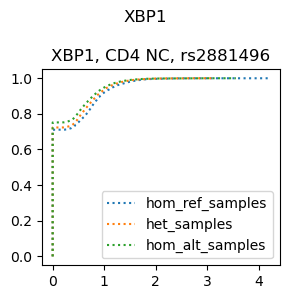

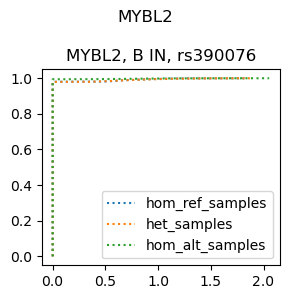

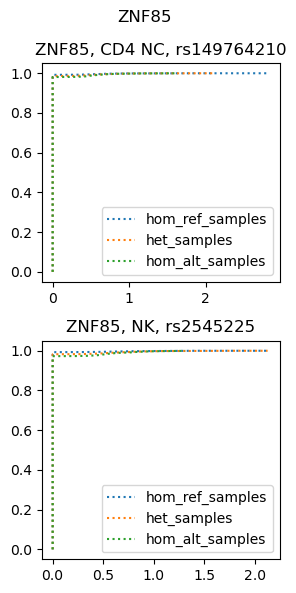

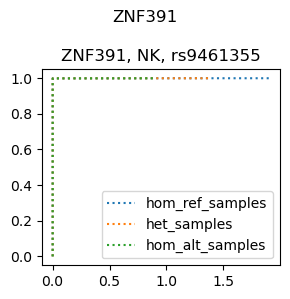

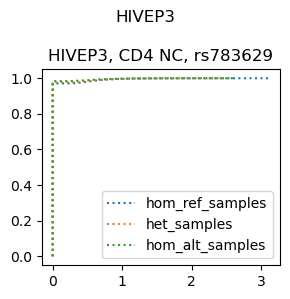

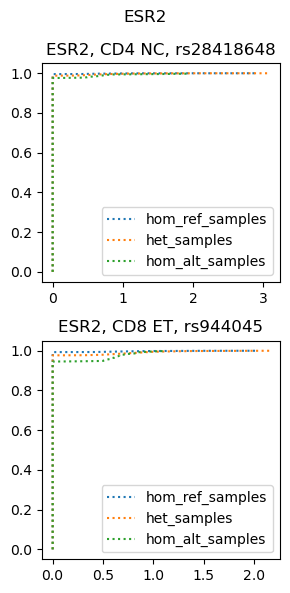

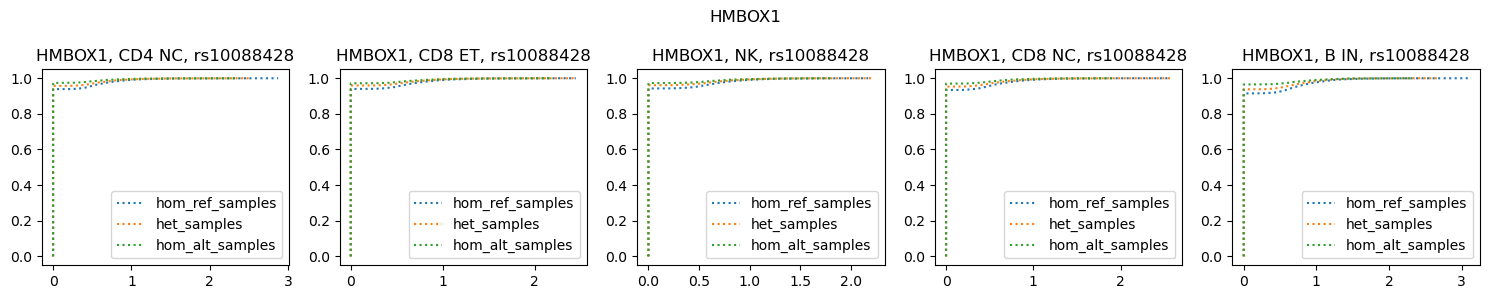

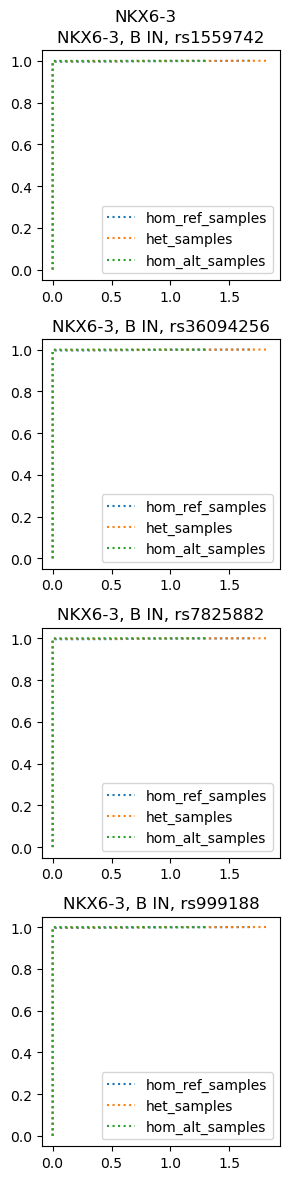

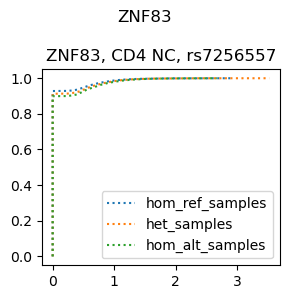

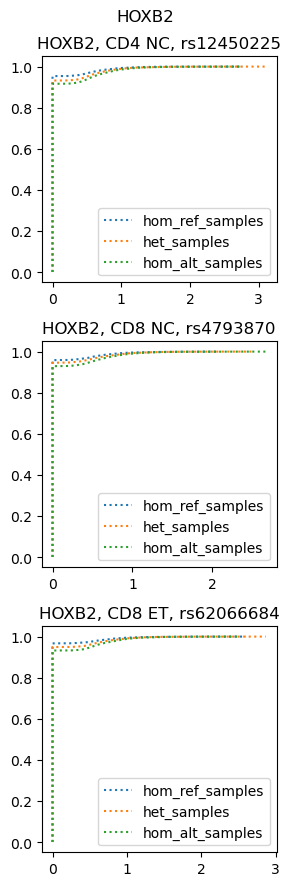

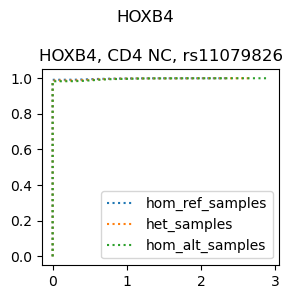

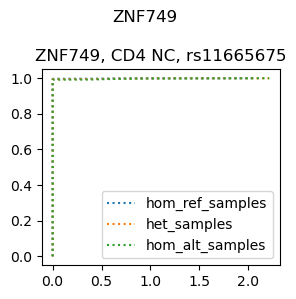

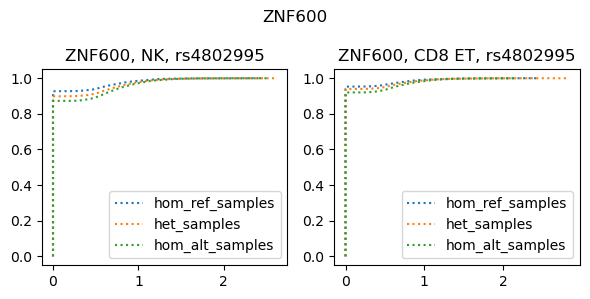

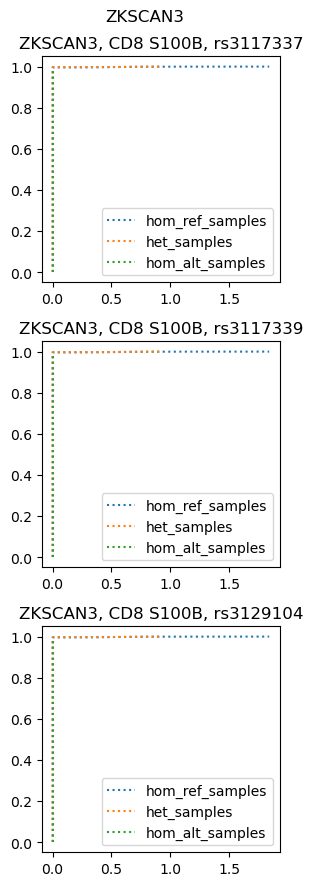

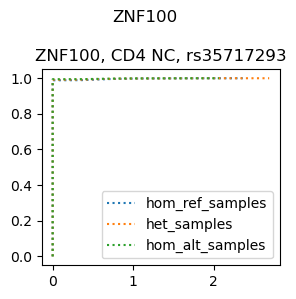

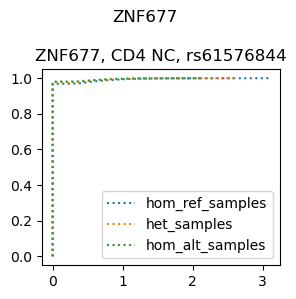

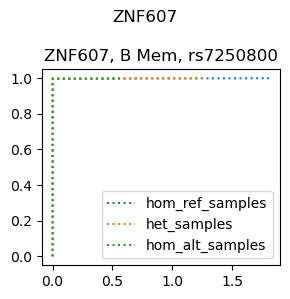

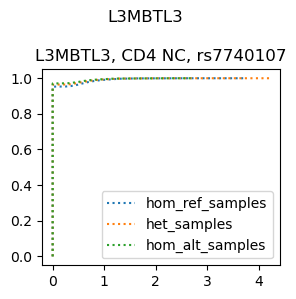

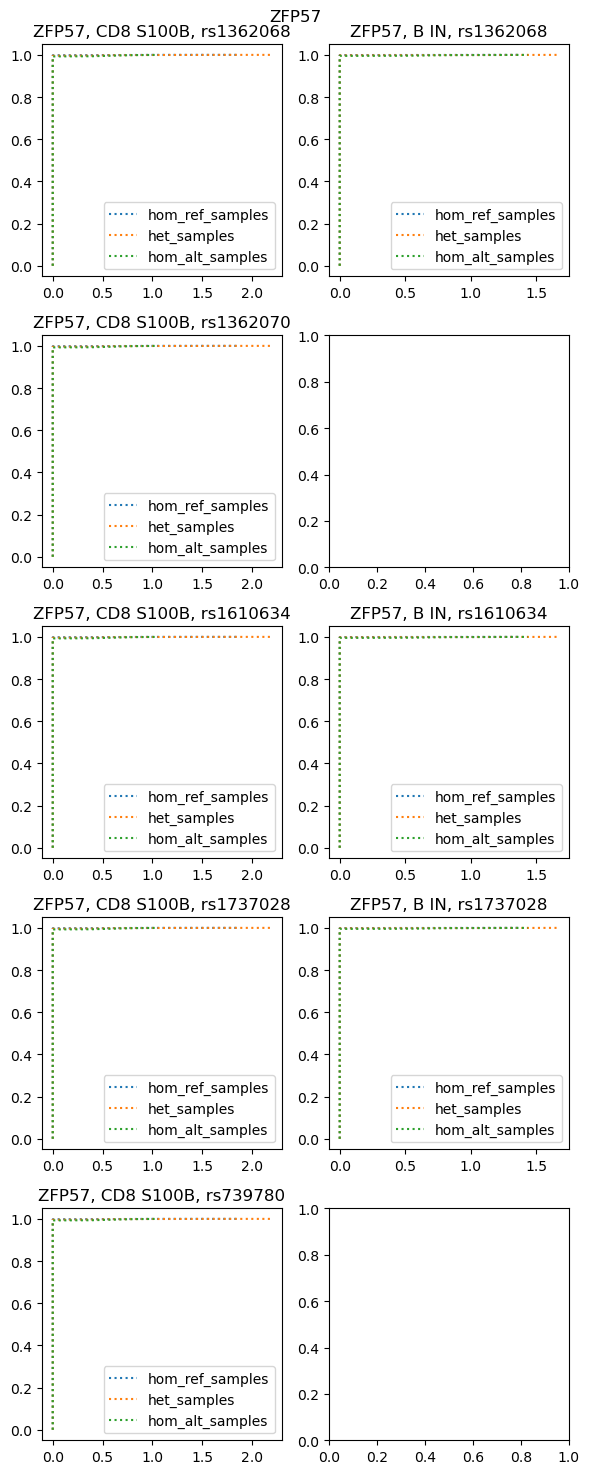

In [98]:
n = 40
for gene in np.unique(tf_eqtl_sort.iloc[:n, :]['Gene Ensembl ID']):
    cdf_by_gene(gene, tf_eqtl_sort.index.values[:n])

Plot only non-zero values

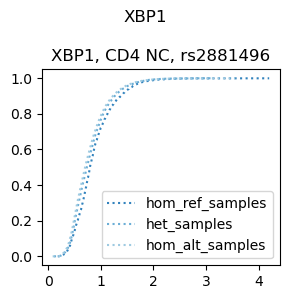

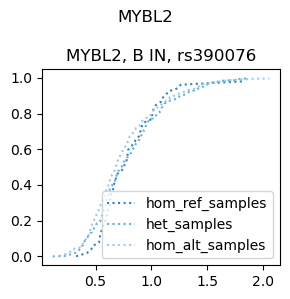

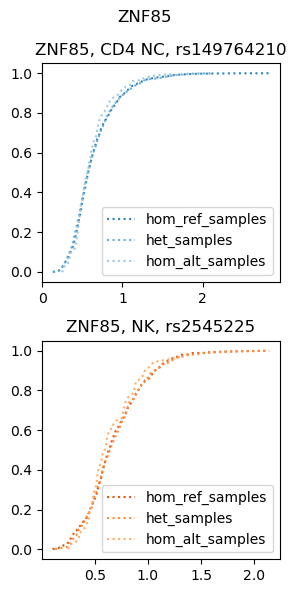

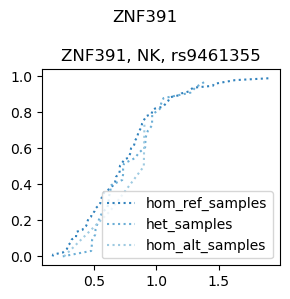

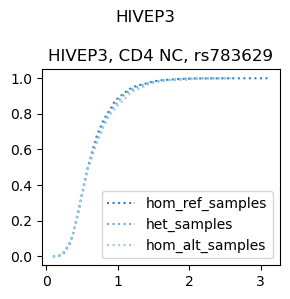

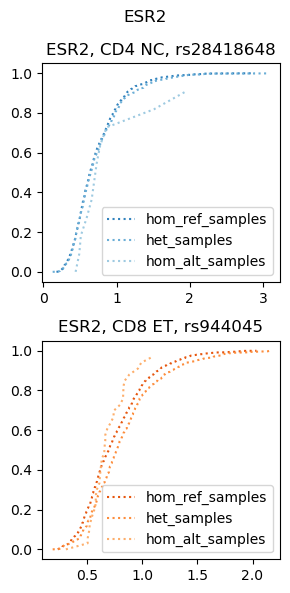

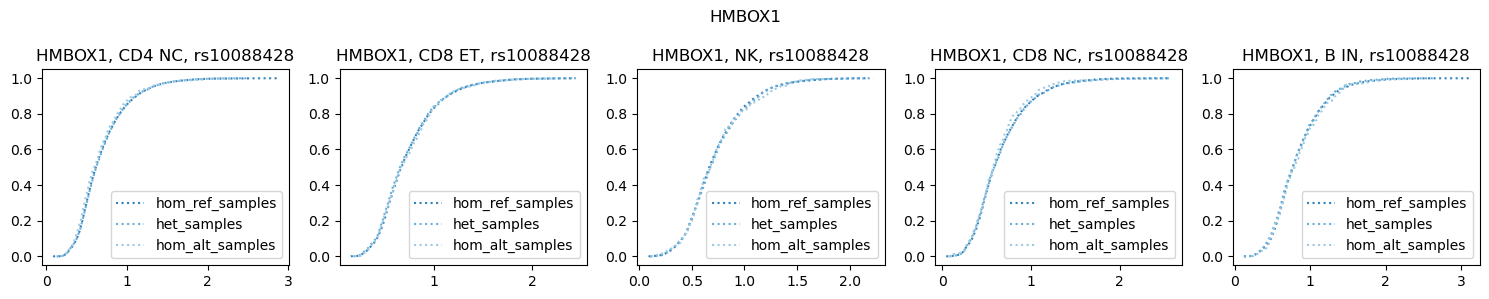

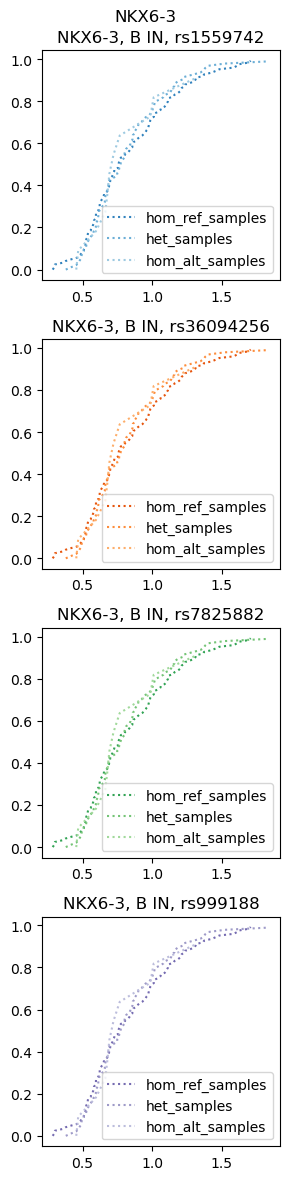

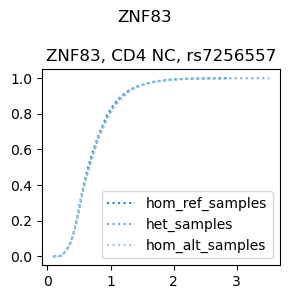

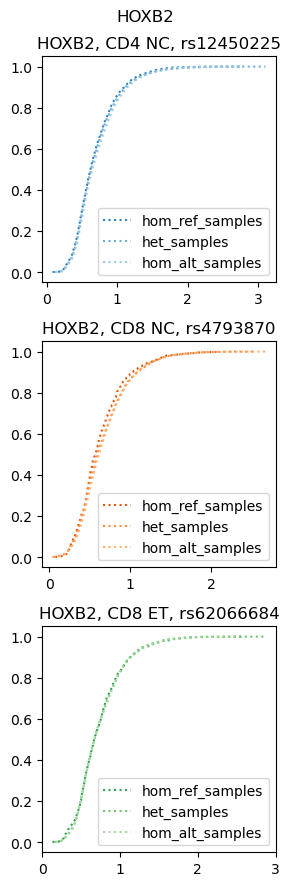

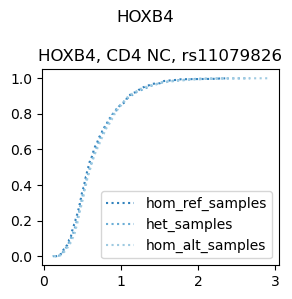

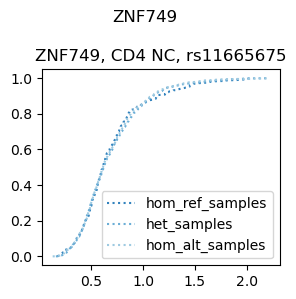

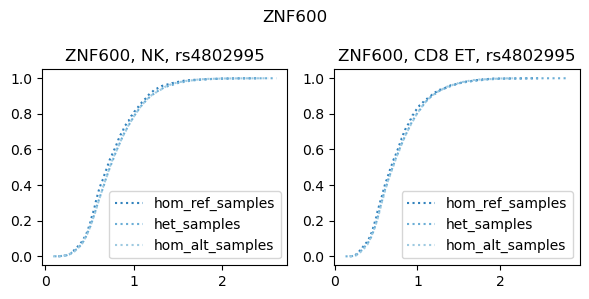

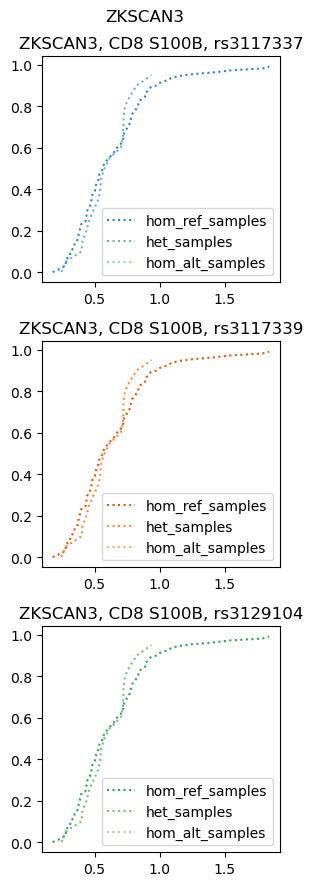

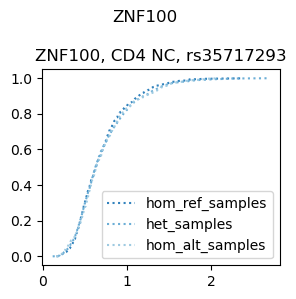

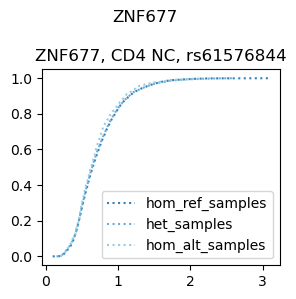

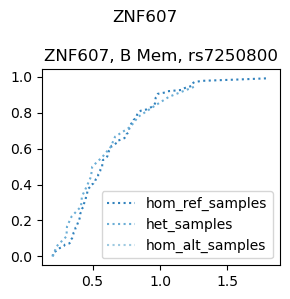

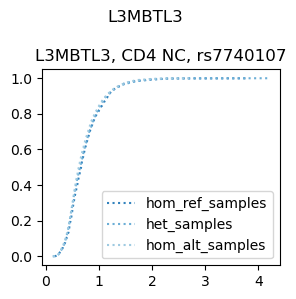

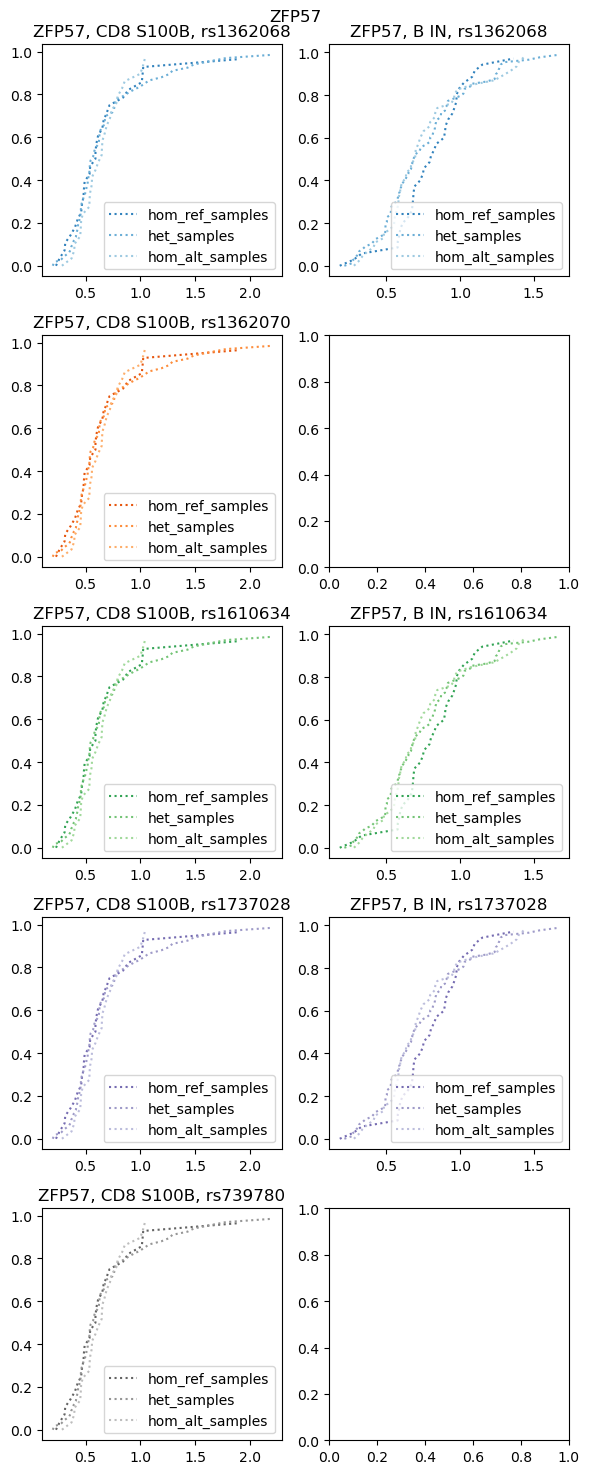

In [18]:
n = 40
for gene in np.unique(tf_eqtl_sort.iloc[:n, :]['Gene Ensembl ID']):
    cdf_by_gene(gene, tf_eqtl_sort.index.values[:n], delete_zeros=True)

# Wasserstein distance

Submitted as a job (src/get_distance.py).

In [142]:
# dist = np.zeros(eqtl.shape[0]) 
# colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
# for snp in [0]:#tqdm(range(eqtl.shape[0])):
#     ok = True
#     expr_list = []
#     for col in [0, 2]:
#         search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
#         if type(search_str)==str:
#             search_str = search_str.replace(',', '|') # Transform to regex

#             gene = eqtl.loc[snp, 'Gene Ensembl ID']
#             cell_type = eqtl.loc[snp, 'Cell type']

#             mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
#                                   data.obs['old_cell_label']==cell_type)

#             x = data[mask, gene].X.copy().todense()
#             expr_list.append(np.array(x).T[0])
             
#         else:
#             ok = False
#             print(f'Not a string at row {snp}, column {col}')
            
#     if ok:
#         dist = stats.wasserstein_distance(expr_list[0], expr_list[1])

## Wasserstein distance results: TFs

In [11]:
dist = np.load('/home/e860a/chernova/my_onek1k_data/distances_tests/wasserstein_homref_homalt_181118-300323_tf.npy')
dist.shape

(1326,)

<Axes: ylabel='Count'>

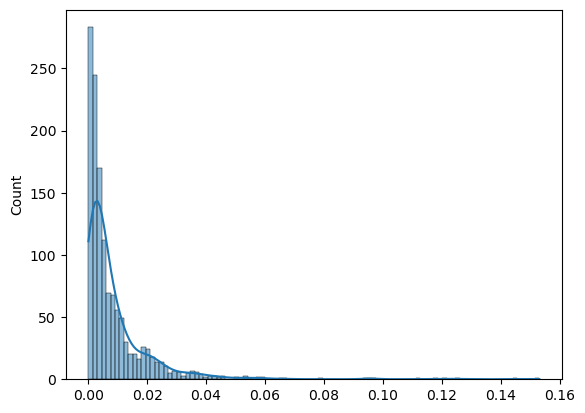

In [19]:
sn.histplot(dist, kde=True)

<Axes: ylabel='Count'>

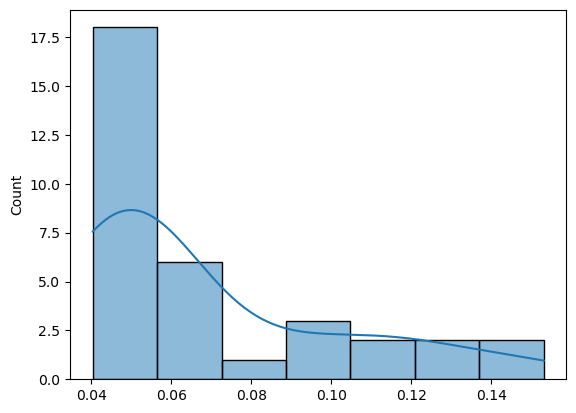

In [20]:
sn.histplot(dist[dist>=0.04], kde=True)

In [21]:
dist[dist>0.05].shape

(20,)

Plotting eQTLs qith the top 20 distances

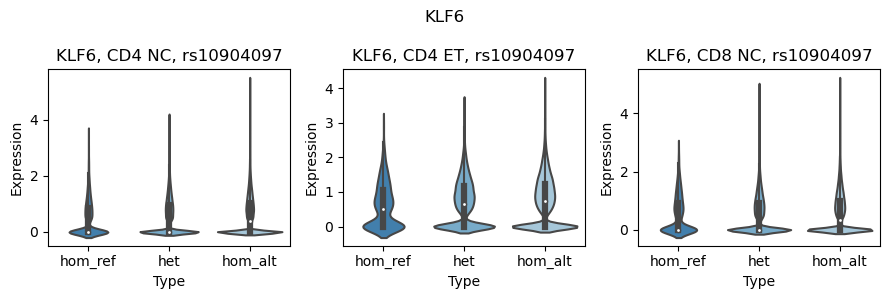

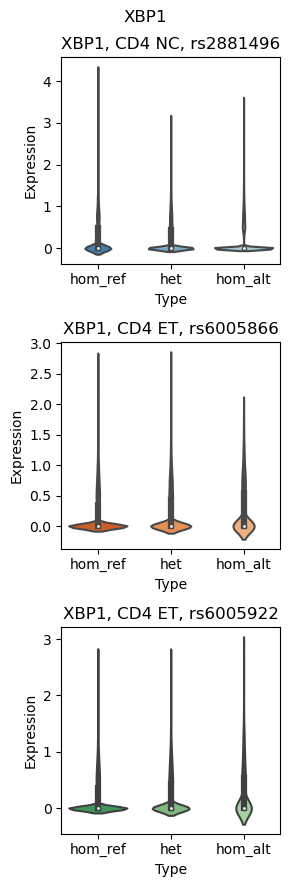

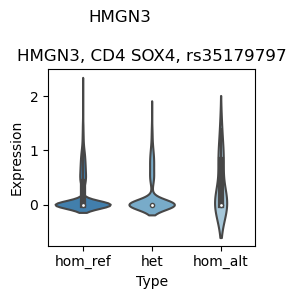

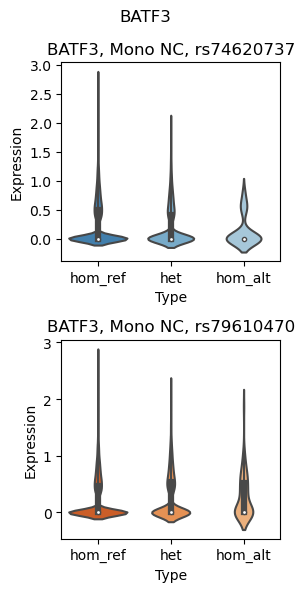

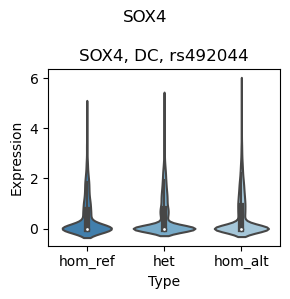

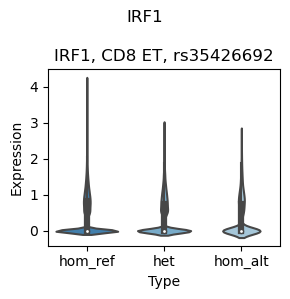

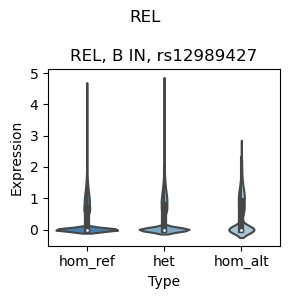

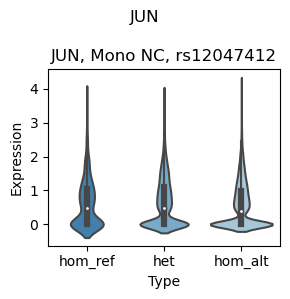

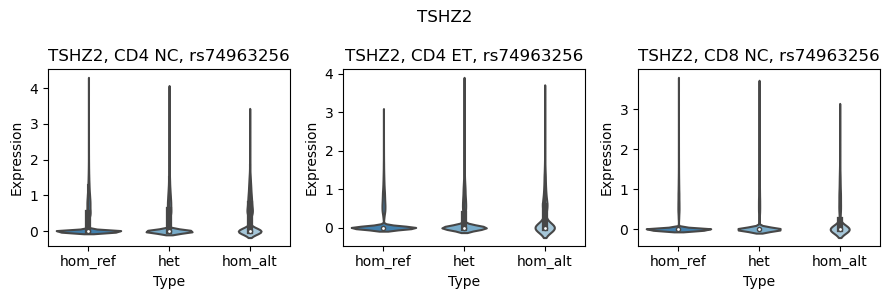

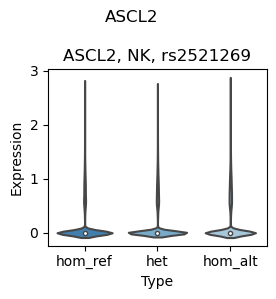

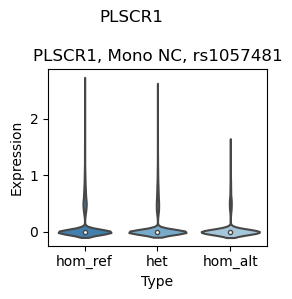

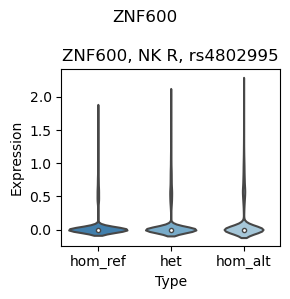

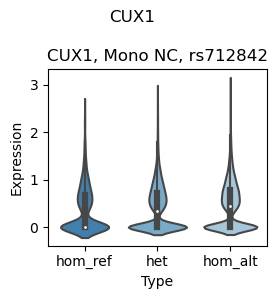

In [36]:
selected_snps = tf_eqtl.index.values[dist>0.05]
for gene in np.unique(tf_eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps, savefig=f'./figures/{gene}_wasserstein_cdf.png')

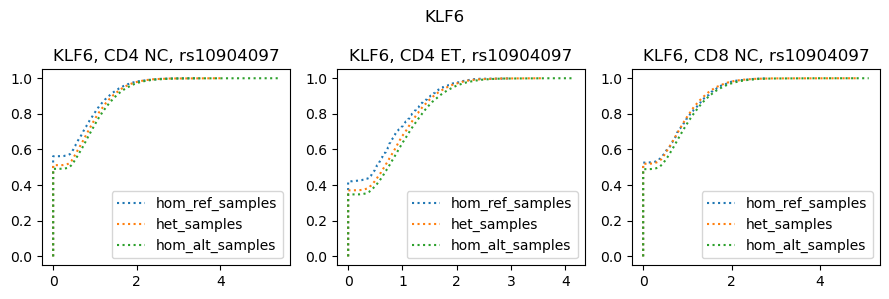

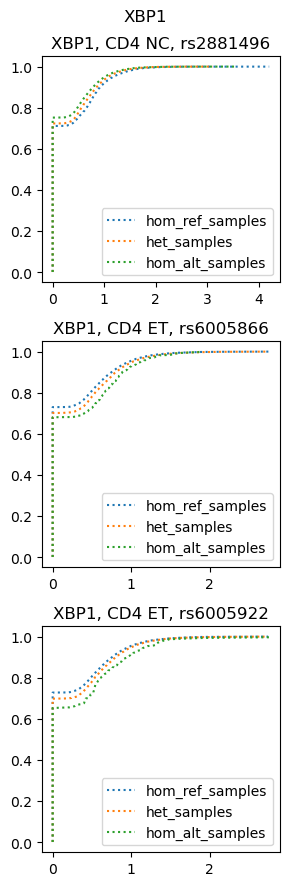

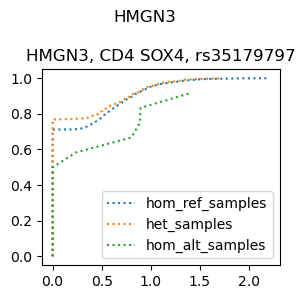

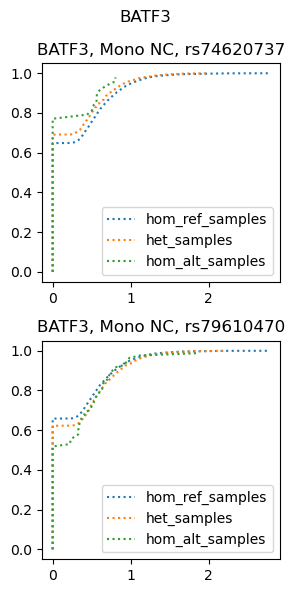

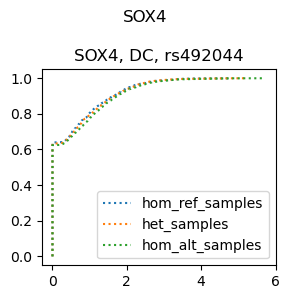

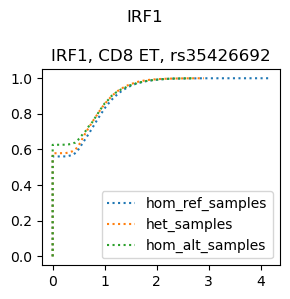

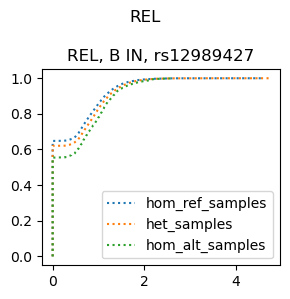

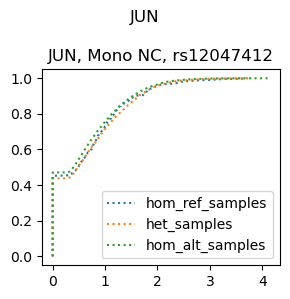

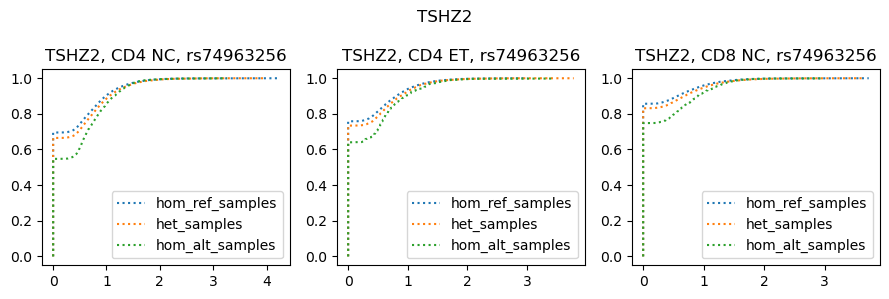

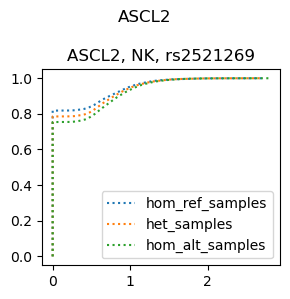

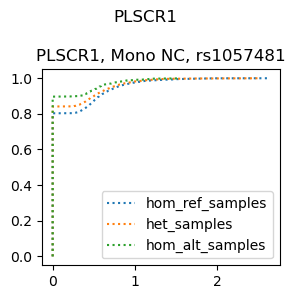

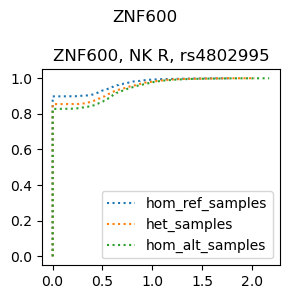

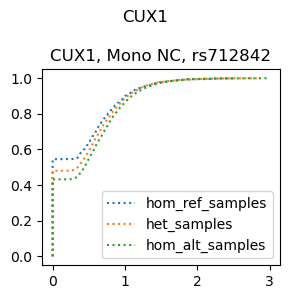

In [176]:
for gene in np.unique(tf_eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    cdf_by_gene(gene, selected_snps)

# Kolmogorov-Smirnov test

Submitted as a job (`get_ks_test_tf.py`).

In [177]:
# dist = np.zeros(eqtl.shape[0]) 
# colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
# for snp in [0]:#tqdm(range(eqtl.shape[0])):
#     ok = True
#     expr_list = []
#     for col in [0, 2]:
#         search_str = eqtl.loc[snp, colnames[col]] # Select the string with the right patients
#         if type(search_str)==str:
#             search_str = search_str.replace(',', '|') # Transform to regex

#             gene = eqtl.loc[snp, 'Gene Ensembl ID']
#             cell_type = eqtl.loc[snp, 'Cell type']

#             mask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
#                                   data.obs['old_cell_label']==cell_type)

#             x = data[mask, gene].X.copy().todense()
#             expr_list.append(np.array(x).T[0])
             
#         else:
#             ok = False
#             print(f'Not a string at row {snp}, column {col}')
            
#     if ok:
#         print(expr_list[0])
#         dist = stats.ks_2samp(expr_list[0], expr_list[1])

## Kolmogorov-Smirnov results: TFs

In [178]:
test = np.load('/home/e860a/chernova/my_onek1k_data/ks_homref_homalt_174350-300323_tf.npz')
test.files

['stat', 'pvalue', 'df']

In [189]:
pvals = test['pvalue']

<Axes: ylabel='Count'>

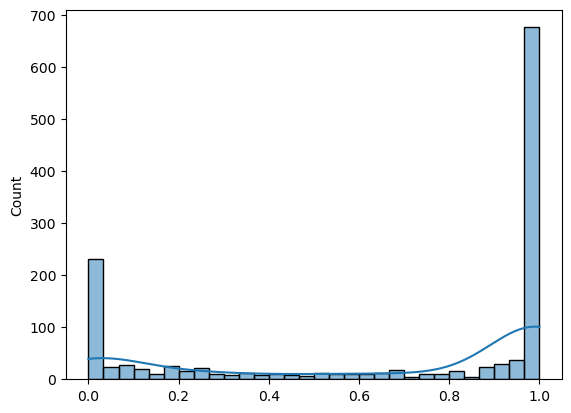

In [191]:
sn.histplot(pvals, kde=True, bins=30)

<Axes: ylabel='Count'>

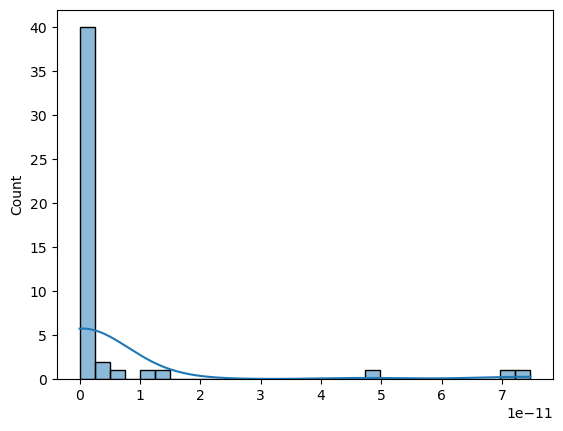

In [201]:
sn.histplot(pvals[pvals<1e-10], kde=True, bins=30)

In [203]:
np.sum(pvals<1e-11)

43

Plot eQTLs with the top p-values for the Kolmogorov-Smirnov test.

/tmp/ipykernel_8761/744914357.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(rows, columns)


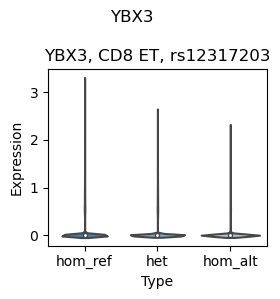

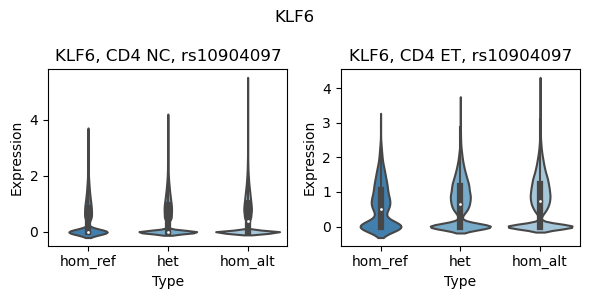

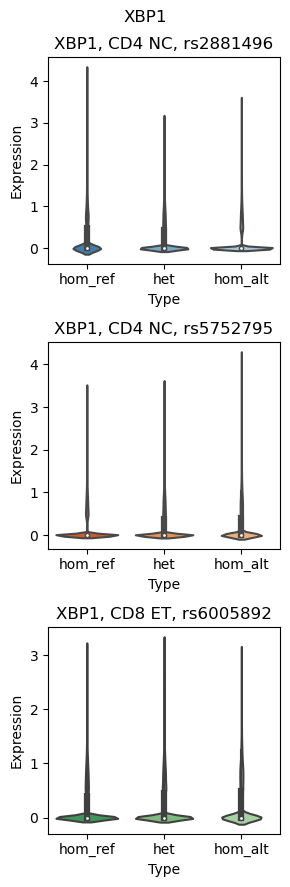

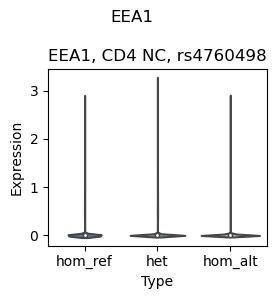

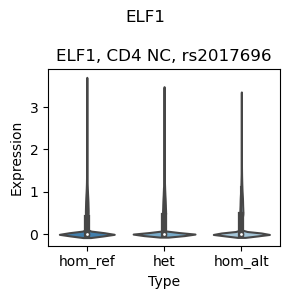

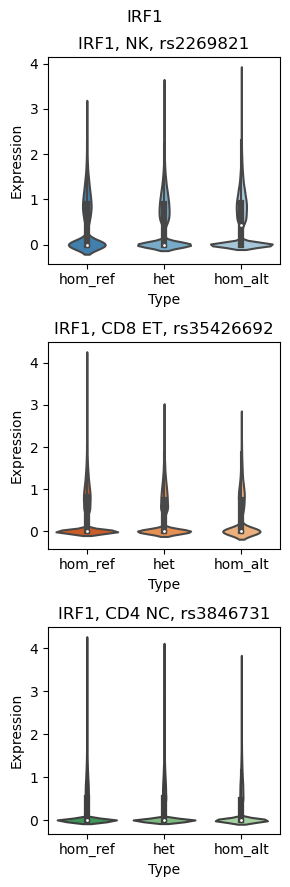

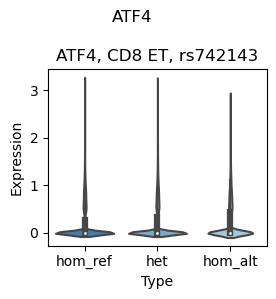

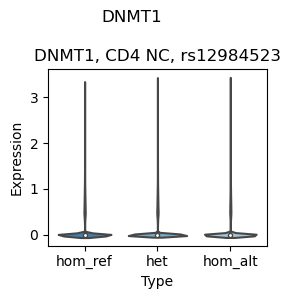

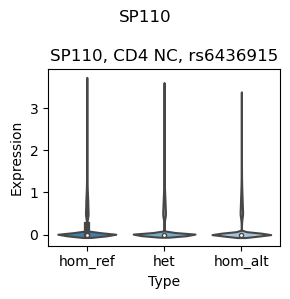

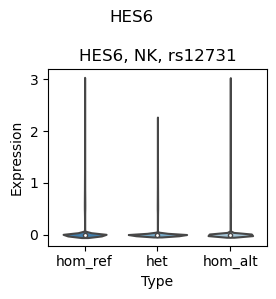

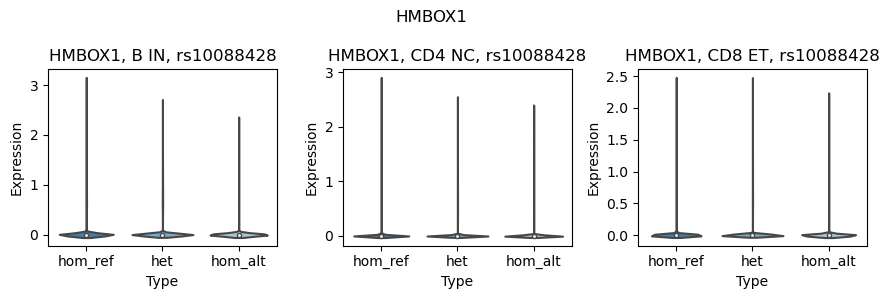

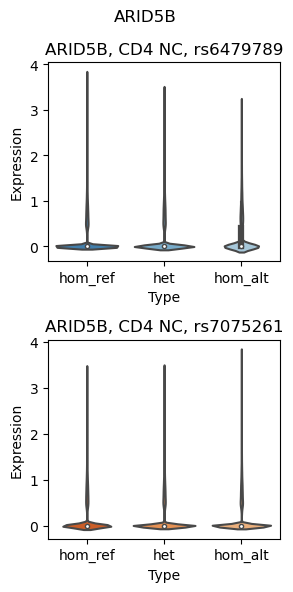

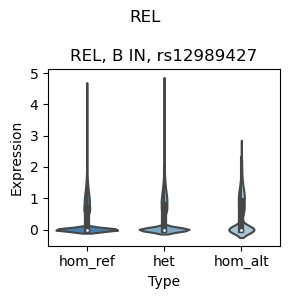

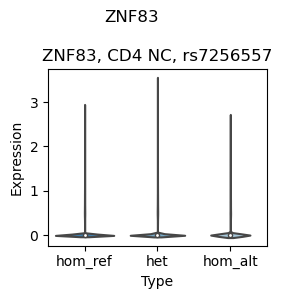

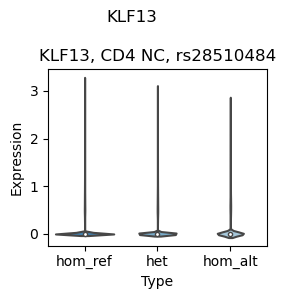

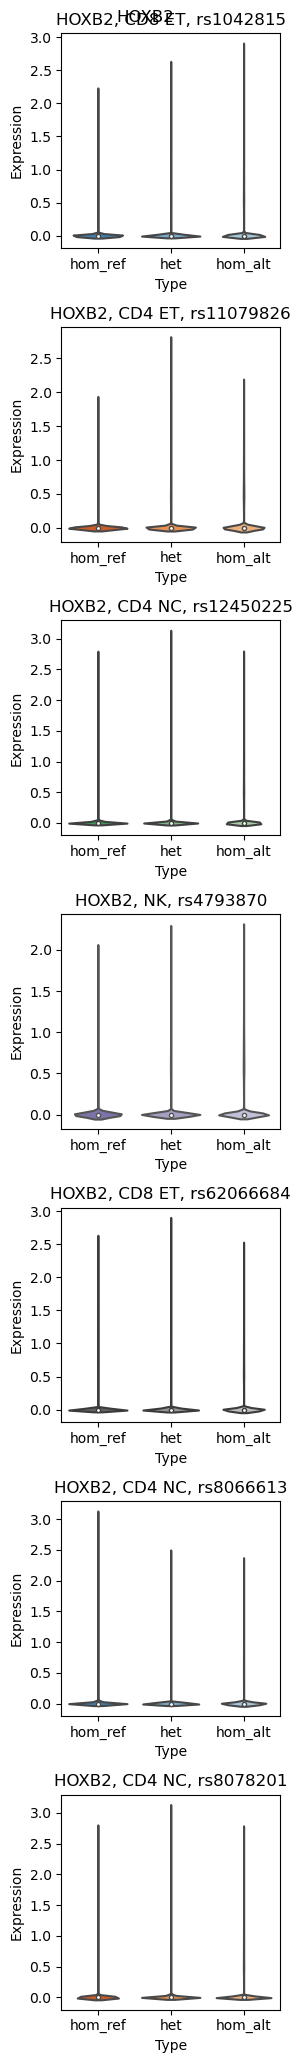

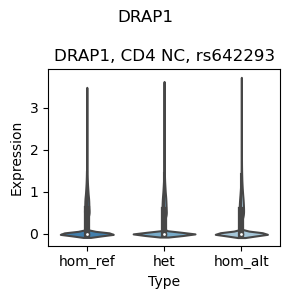

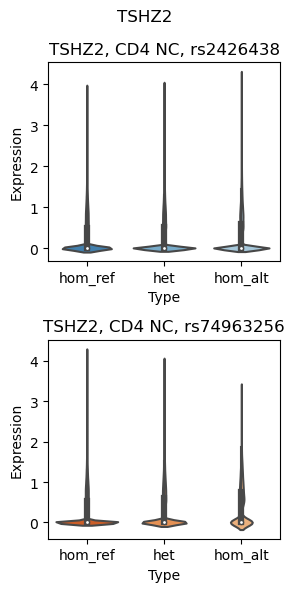

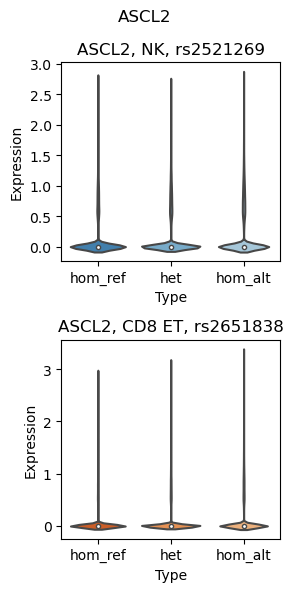

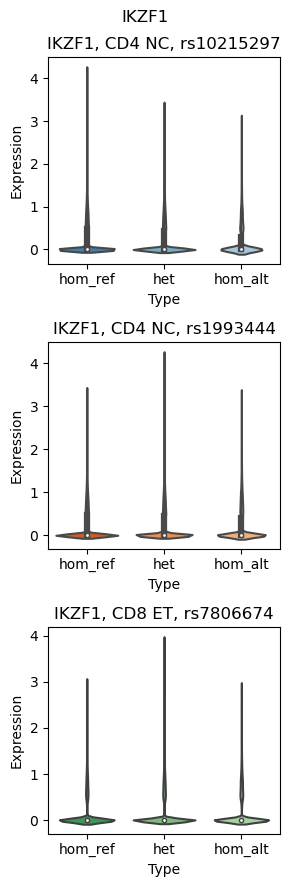

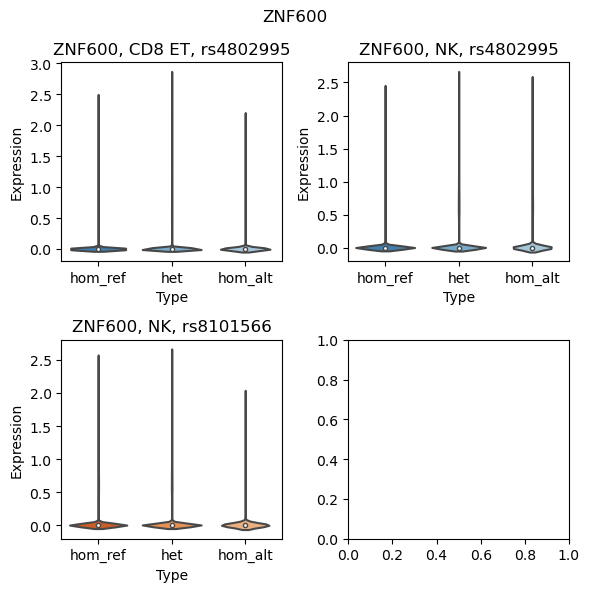

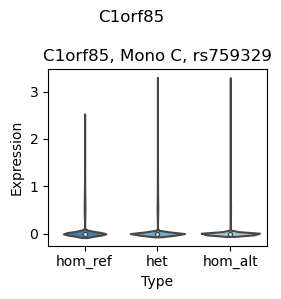

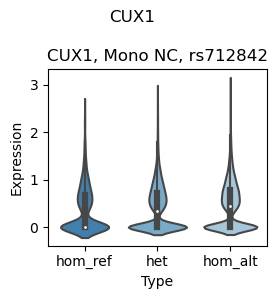

In [228]:
selected_snps = tf_eqtl.index.values[pvals<1e-11]
for gene in np.unique(tf_eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps)

/tmp/ipykernel_8761/3677347524.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(rows, columns)


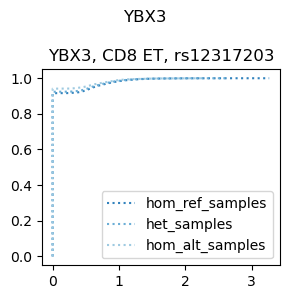

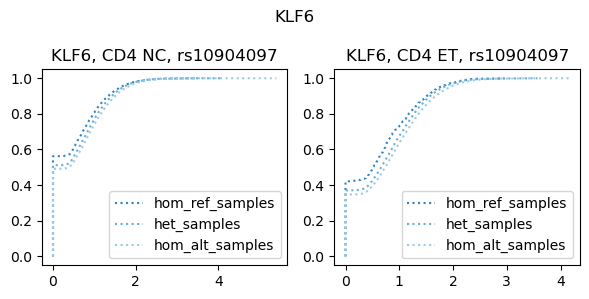

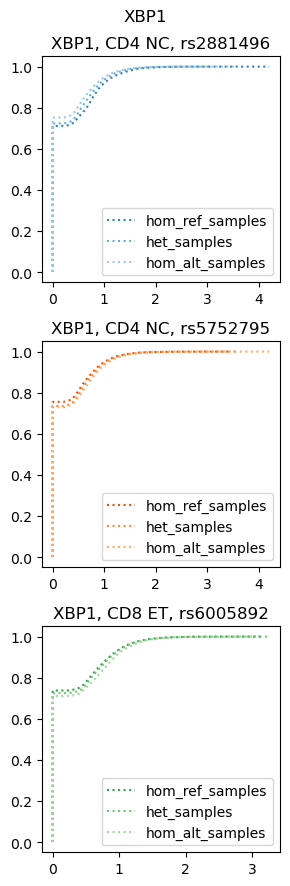

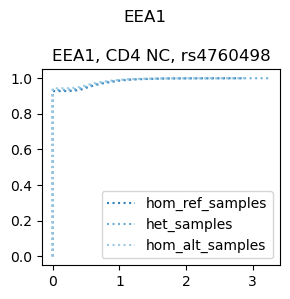

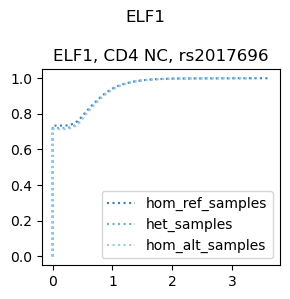

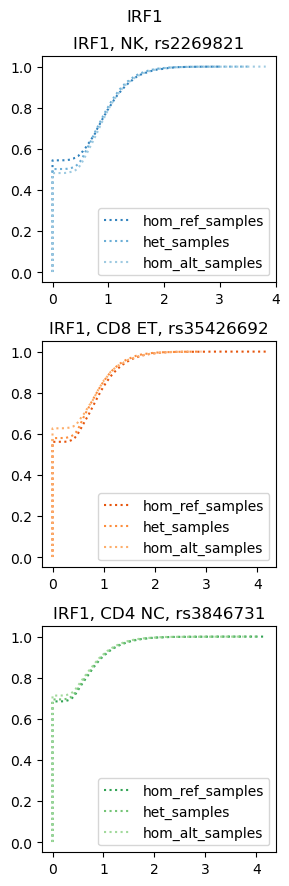

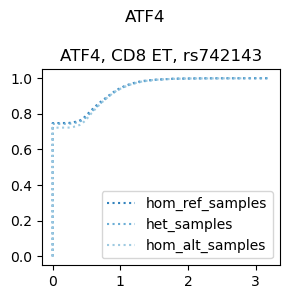

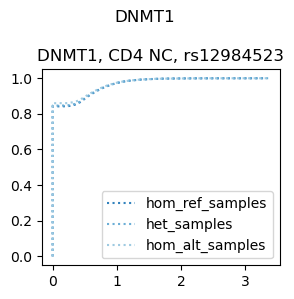

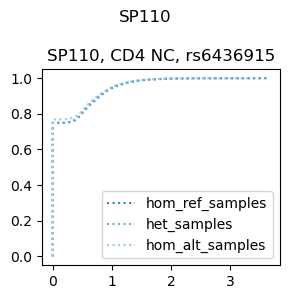

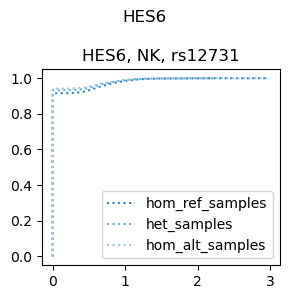

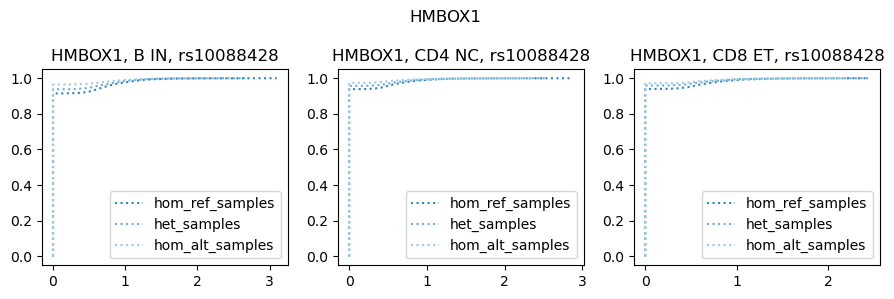

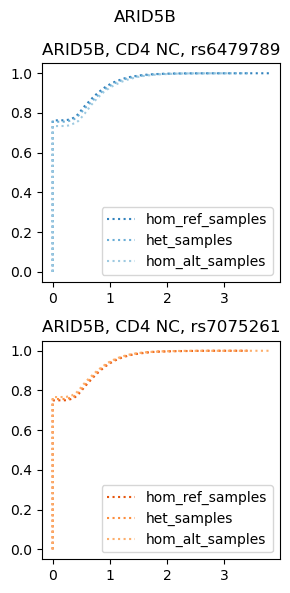

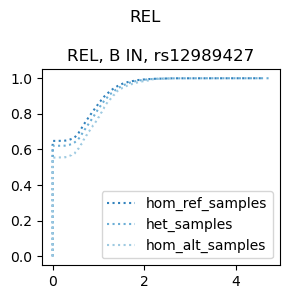

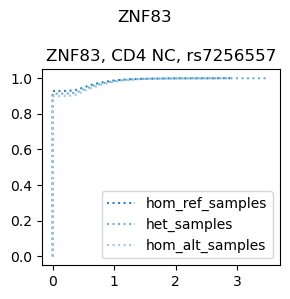

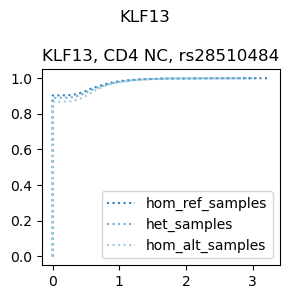

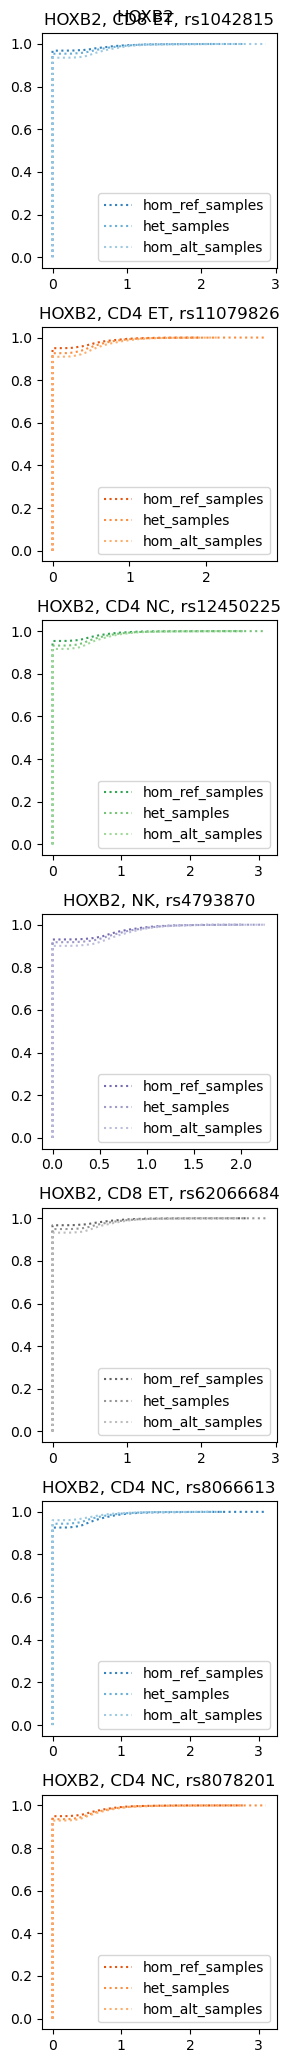

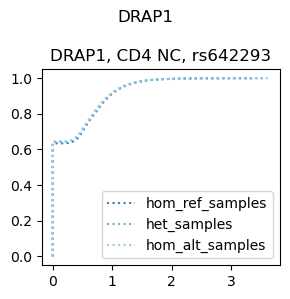

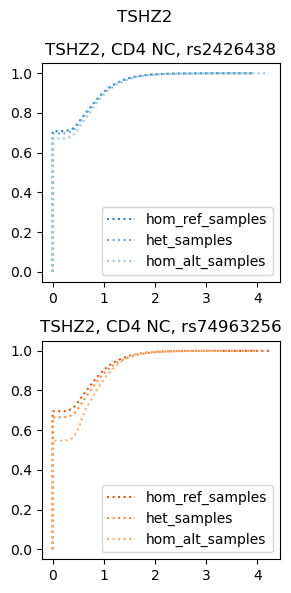

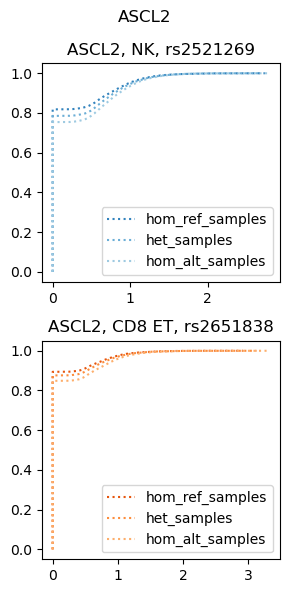

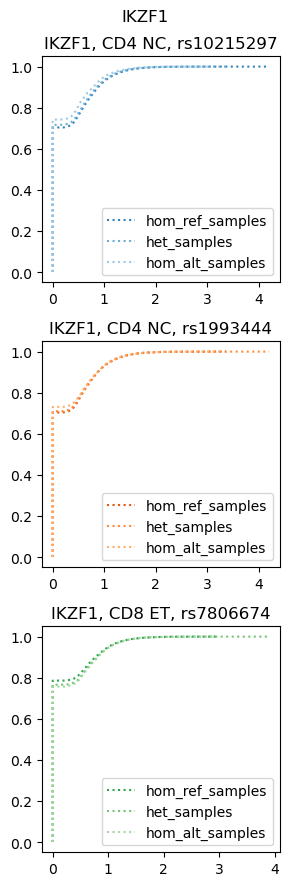

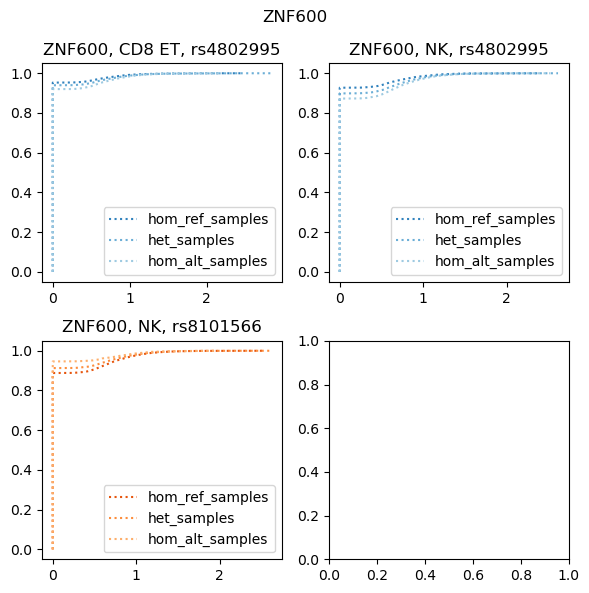

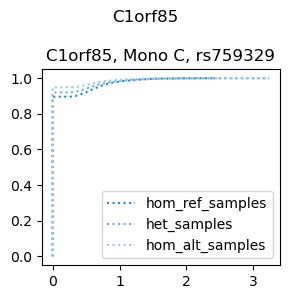

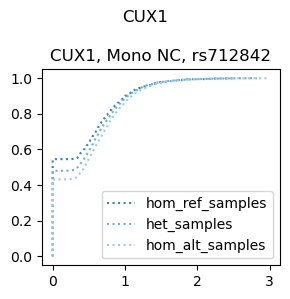

In [227]:
selected_snps = tf_eqtl.index.values[pvals<1e-11]
for gene in np.unique(tf_eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    cdf_by_gene(gene, selected_snps)

## Kolmogorov-Smirnov results: all eQTLs

In [229]:
test = np.load('/home/e860a/chernova/my_onek1k_data/ks_homref_homalt_014639-310323.npz')
test.files

['stat', 'pvalue', 'df']

In [230]:
pvals = test['pvalue']

<Axes: ylabel='Count'>

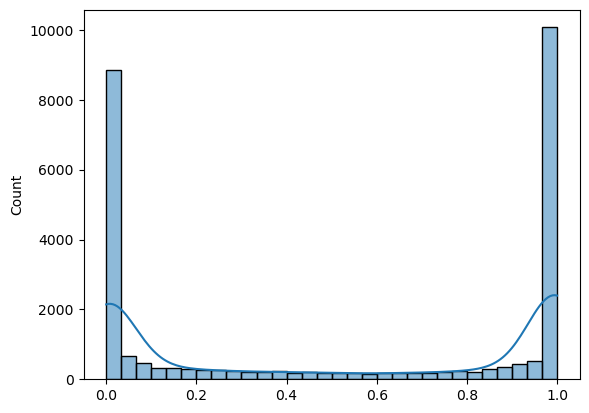

In [231]:
sn.histplot(pvals, kde=True, bins=30)

<Axes: ylabel='Count'>

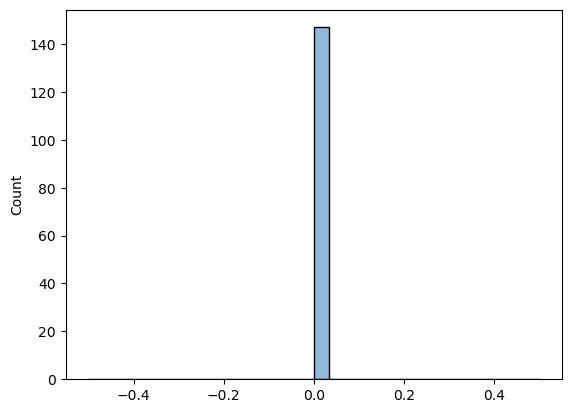

In [234]:
sn.histplot(pvals[pvals==0], kde=True, bins=30)

In [239]:
np.sum(pvals==0)

147

In [237]:
stat = test['stat']

<Axes: ylabel='Count'>

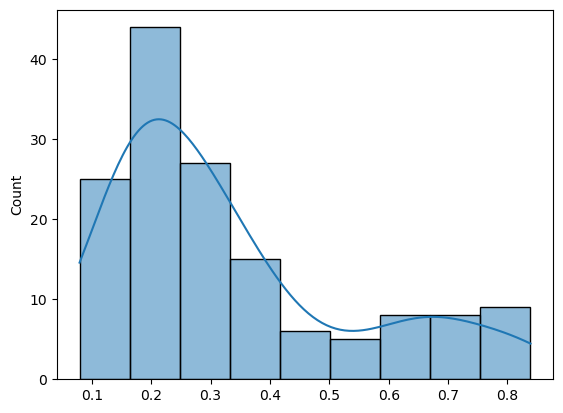

In [242]:
sn.histplot(stat[pvals==0], kde=True)

In [244]:
np.sum(np.logical_and(pvals==0, stat>=0.5))

30

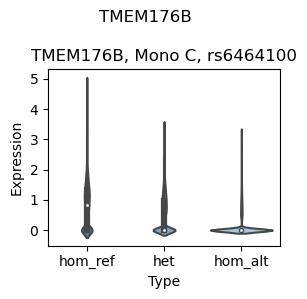

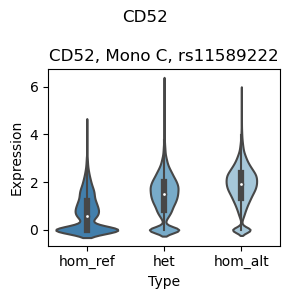

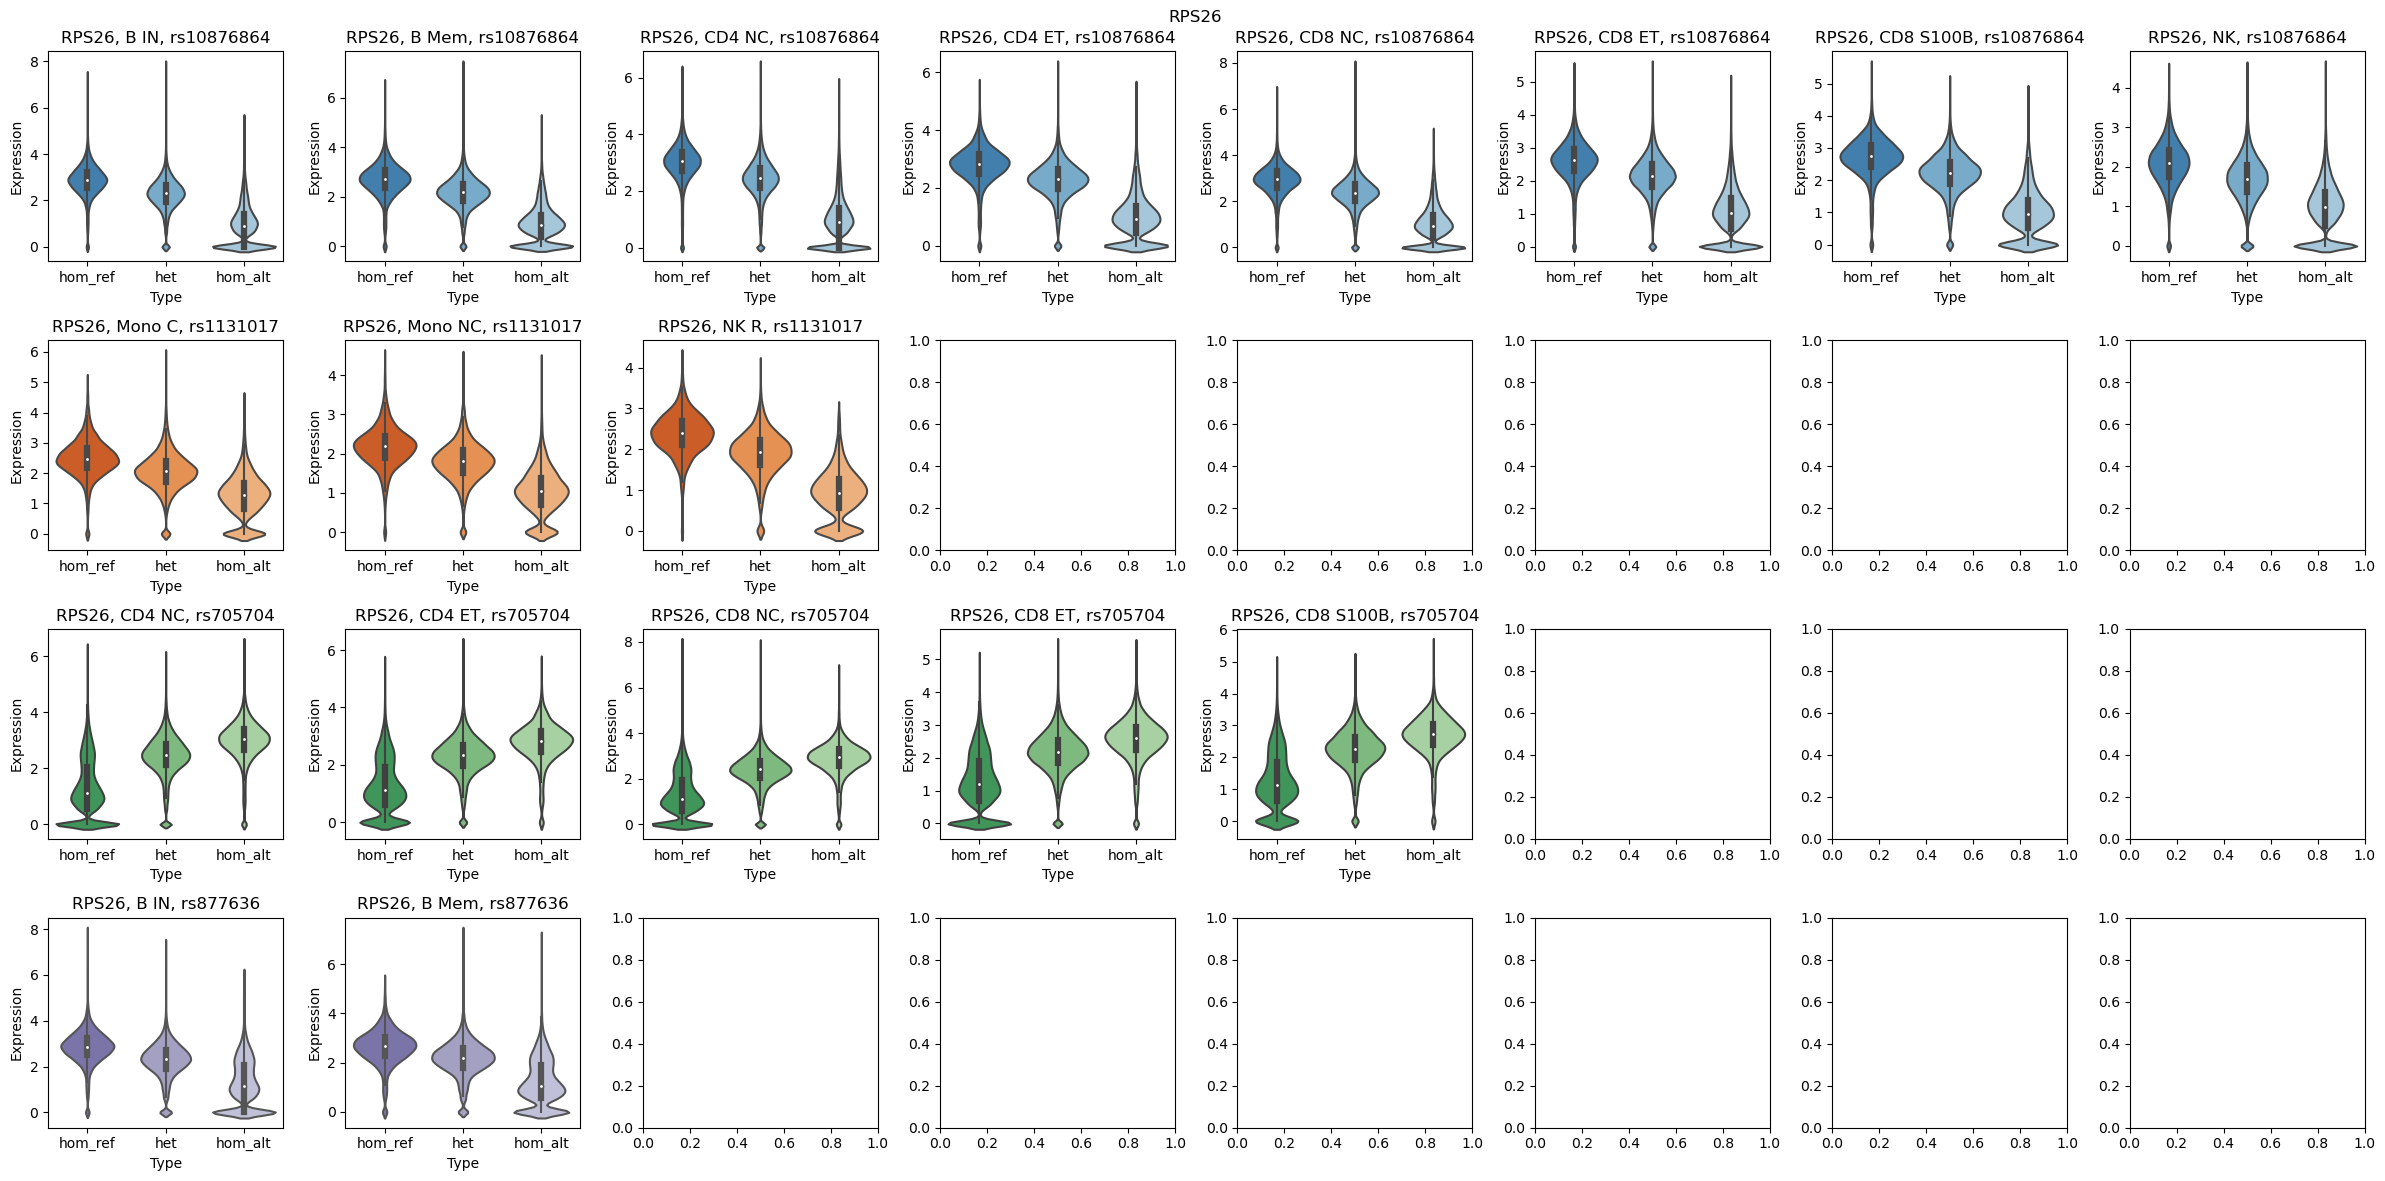

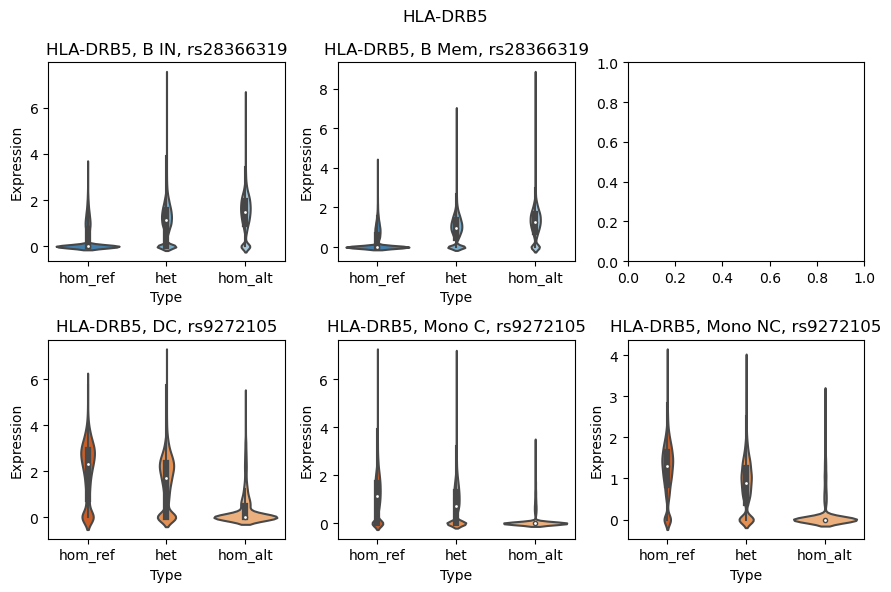

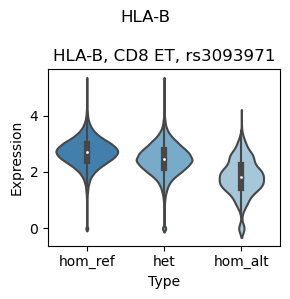

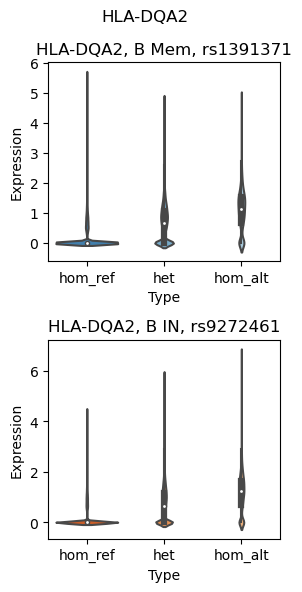

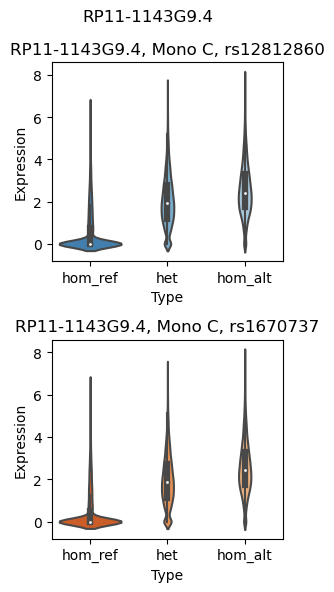

In [245]:
mask = np.logical_and(pvals==0, stat>=0.5)
selected_snps = eqtl.index.values[mask]
for gene in np.unique(eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    plot_by_gene(gene, selected_snps)

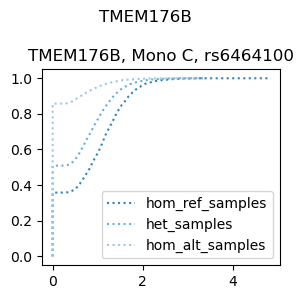

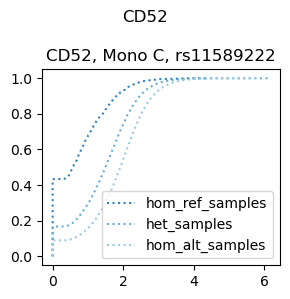

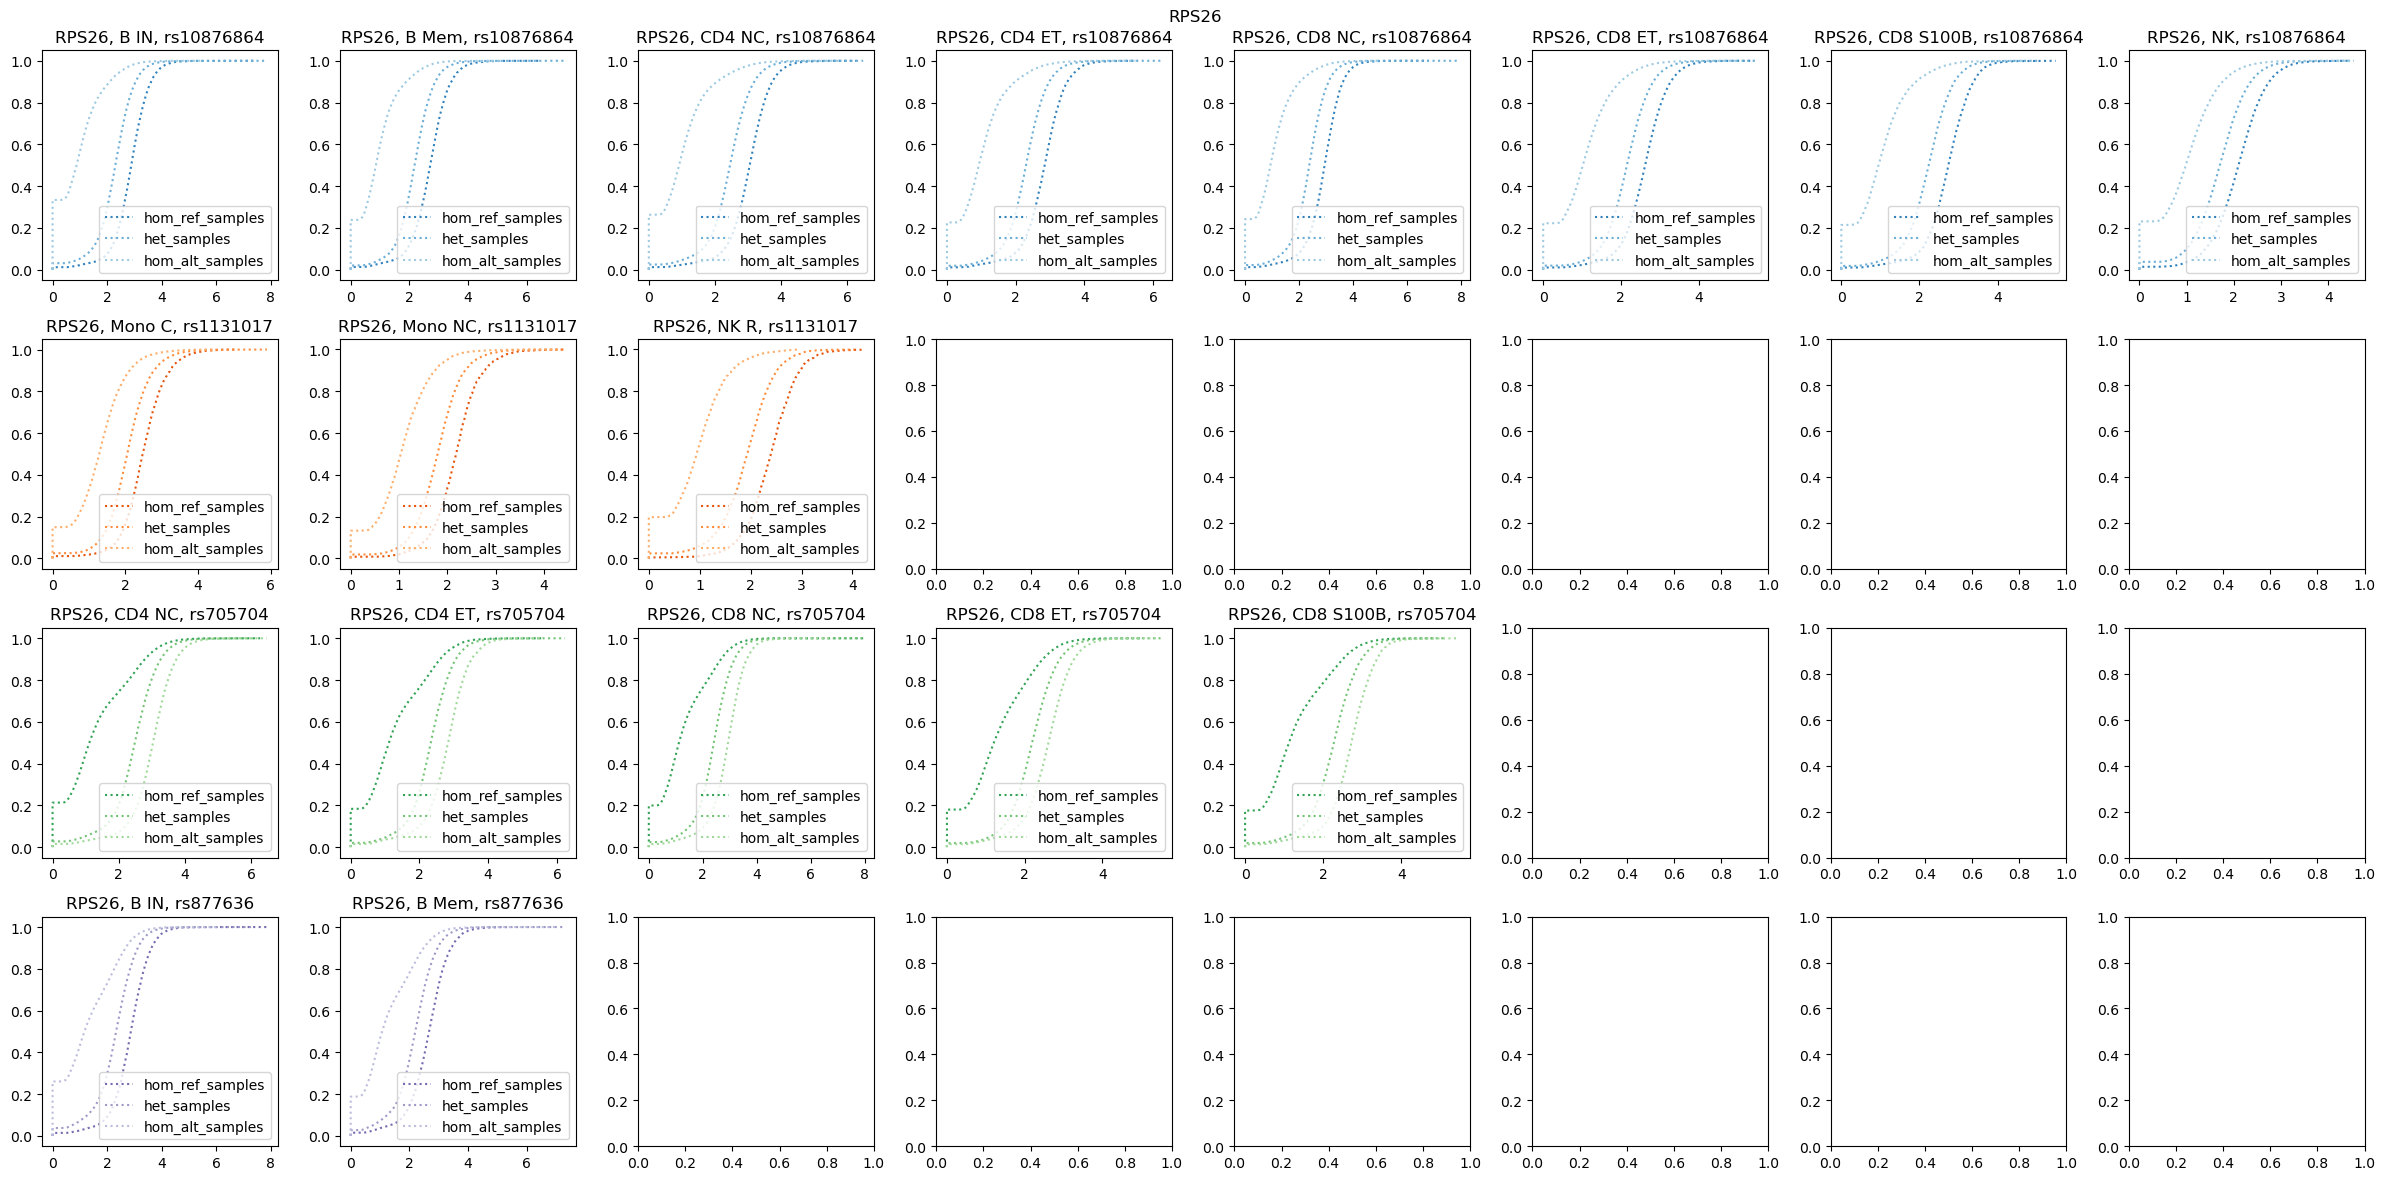

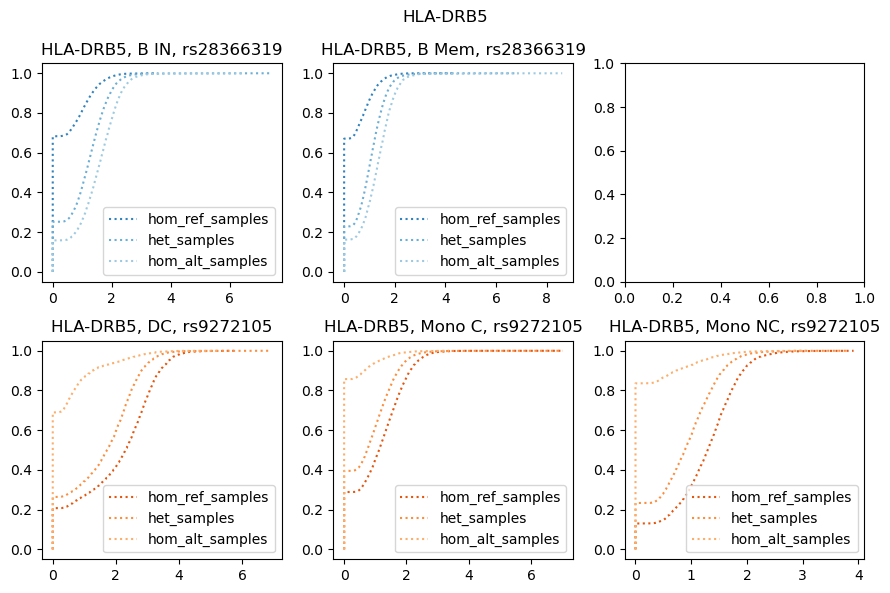

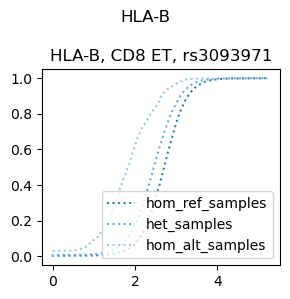

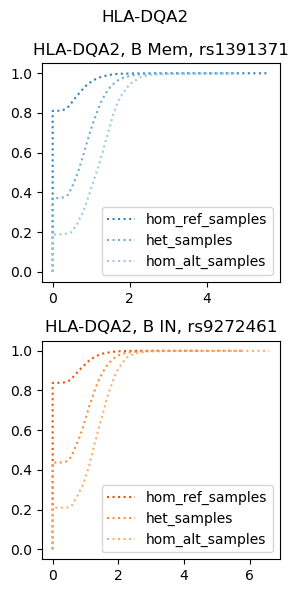

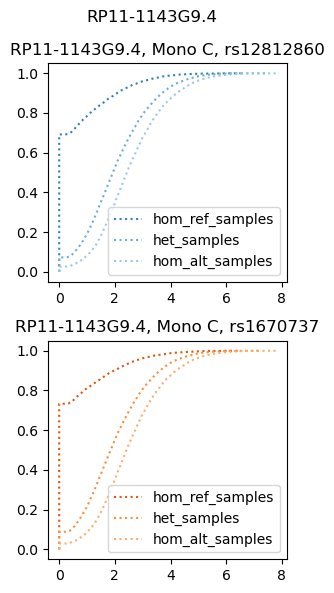

In [246]:
mask = np.logical_and(pvals==0, stat>=0.5)
selected_snps = eqtl.index.values[mask]
for gene in np.unique(eqtl.loc[selected_snps,  'Gene Ensembl ID']):
    cdf_by_gene(gene, selected_snps)

# Example of a know pathway

#### KLF6 - Aryl hydrocarbon receptor pathway
- CD4 NC, CD4 ET, (CD8 NC)
- This gene encodes a member of the Kruppel-like family of transcription factors. The zinc finger protein is a transcriptional activator, and functions as a tumor suppressor. Multiple transcript variants encoding different isoforms have been found for this gene, some of which are implicated in carcinogenesis.
- https://string-db.org/cgi/network?taskId=bVGMVJpUAbQj&sessionId=bGOqpwErwzrz
- As an immune response-associated transcriptional regulator, KLF6 is also involved in regulating NO production by directly transactivating the expression of inducible nitric oxide synthase (iNOS) in response to environmental stimulants or challenges (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7601070/)
- iNOS = NOS2 = ENSG00000007171
- Part of Aryl hydrocarbon receptor pathway (https://www.wikipathways.org/pathways/WP2586.html): KLF6 -> AHR/ARNT -> upregulated expression of CYP1A1/1A2/1B1

In [259]:
# iNOS
'ENSG00000007171' in data.var.index.values

True

In [260]:
# SP1
'ENSG00000185591' in data.var.index.values

True

In [263]:
# CYP1A1
'ENSG00000140465' in data.var.index.values

True

In [264]:
# CYP1A2
'ENSG00000140505' in data.var.index.values

True

In [265]:
# CYP1B1
'ENSG00000138061' in data.var.index.values

True

In [268]:
# AhR
'ENSG00000106546' in data.var.index.values

True

In [269]:
# ARNT (aryl hydrocarbon receptor nuclear translocator)
'ENSG00000143437' in data.var.index.values

True

In [275]:
# KLF6
eqtl[np.logical_and(eqtl['Gene Ensembl ID']=='ENSG00000067082', eqtl['SNP']=='rs10904097')]

Unnamed: 0 Cell type Gene ID  Gene Ensembl ID         SNP  Chromosome  \
3416         3416    CD4 NC    KLF6  ENSG00000067082  rs10904097          10   
9775         9775    CD4 ET    KLF6  ENSG00000067082  rs10904097          10   
11839       11839    CD8 NC    KLF6  ENSG00000067082  rs10904097          10   

       Position SNP assessed allele eSNP rank  rho correlation coefficient  \
3416    3842600                   C     eSNP1                        0.132   
9775    3842600                   C     eSNP1                        0.144   
11839   3842600                   C     eSNP1                        0.168   

       S-statistics        pvalue    qvalue       FDR  ref_samples  \
3416    136963418.2  3.250000e-05  0.004020  0.034600            0   
9775    135034439.0  5.530000e-06  0.003160  0.017800            0   
11839   131361189.4  1.250000e-07  0.000067  0.000741            0   

                                         hom_ref_samples  \
3416   128_128,153_153,190_191,273_274,403_404,437_43...   
9775   128_128,153_153,190_191,273_274,403_404,437_43...   
11839  128_128,153_153,190_191,273_274,403_404,437_43...   

                                             het_samples  \
3416   8_8,14_14,15_15,20_20,26_26,29_29,37_37,41_41,...   
9775   8_8,14_14,15_15,20_20,26_26,29_29,37_37,41_41,...   
11839  8_8,14_14,15_15,20_20,26_26,29_29,37_37,41_41,...   

                                         hom_alt_samples  
3416   1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,12_12,...  
9775   1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,12_12,...  
11839  1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,12_12,...

In [12]:
targets = {'KLF6':'ENSG00000067082',
           'AhR':'ENSG00000106546',
           'ARNT':'ENSG00000143437',
           'CYP1A1':'ENSG00000140465',
           'CYP1A2':'ENSG00000140505',
           'CYP1B1':'ENSG00000138061'}
egene = 'KLF6'
egene_id = 'ENSG00000067082'
rs = 'rs10904097'

mask = np.logical_and(eqtl['Gene Ensembl ID']=='ENSG00000067082', eqtl['SNP']=='rs10904097')
snps = eqtl[mask].index.values
snps

array([ 3416,  9775, 11839])

In [16]:
colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
class_names = ['hom_ref', 'het', 'hom_alt']

In [282]:
eqtl.loc[mask, 'Cell type']

3416     CD4 NC
9775     CD4 ET
11839    CD8 NC
Name: Cell type, dtype: object

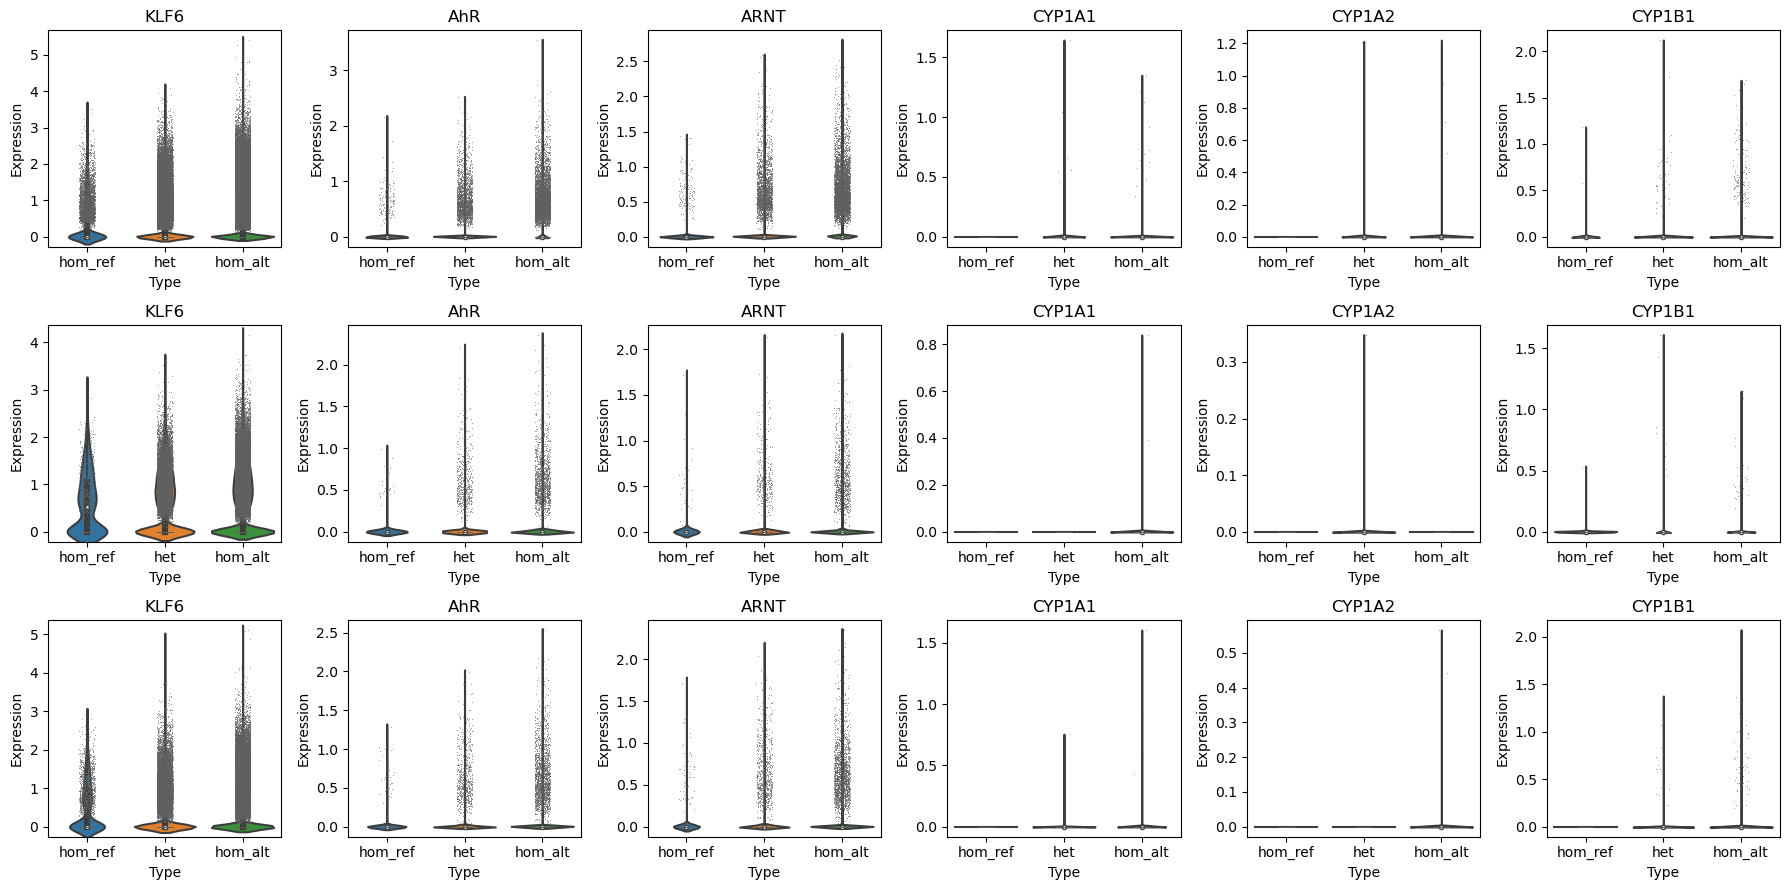

In [18]:
n_cell_types = eqtl[mask].shape[0]
n_genes = len(targets.keys())
fig, ax = plt.subplots(n_cell_types, n_genes)
fig.set_size_inches(3*n_genes, 3*n_cell_types)

for ax_y, cell_type in enumerate(eqtl.loc[mask, 'Cell type']):
    for ax_x, gene in enumerate(targets.keys()):
        axis = ax[ax_y][ax_x]
        expr_list = []
        class_list = []
        
        for col in range(len(colnames)):
            search_str = eqtl.loc[snps[0], colnames[col]] # Select the string with the right patients
            if type(search_str)!=str:
                continue
            search_str = search_str.replace(',', '|') # Transform to regex

            datamask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                  data.obs['old_cell_label']==cell_type)

            x = data[datamask, targets[gene]].to_df().to_numpy().flatten()

            expr_list.append(x.flatten())
            class_list.extend([class_names[col] for i in range(x.shape[0])])
        
        df= pd.DataFrame({'Expression': np.concatenate(expr_list), 'Type': class_list})
        sn.violinplot(df, x='Type', y='Expression', ax=axis)
        sn.stripplot(df, x='Type', y='Expression',
                          ax = axis, size=0.5, color='grey')
        axis.set_title(gene)
plt.tight_layout()
plt.savefig('figures/KLF6_AHR_pathway_violinplots.png', dpi=300)

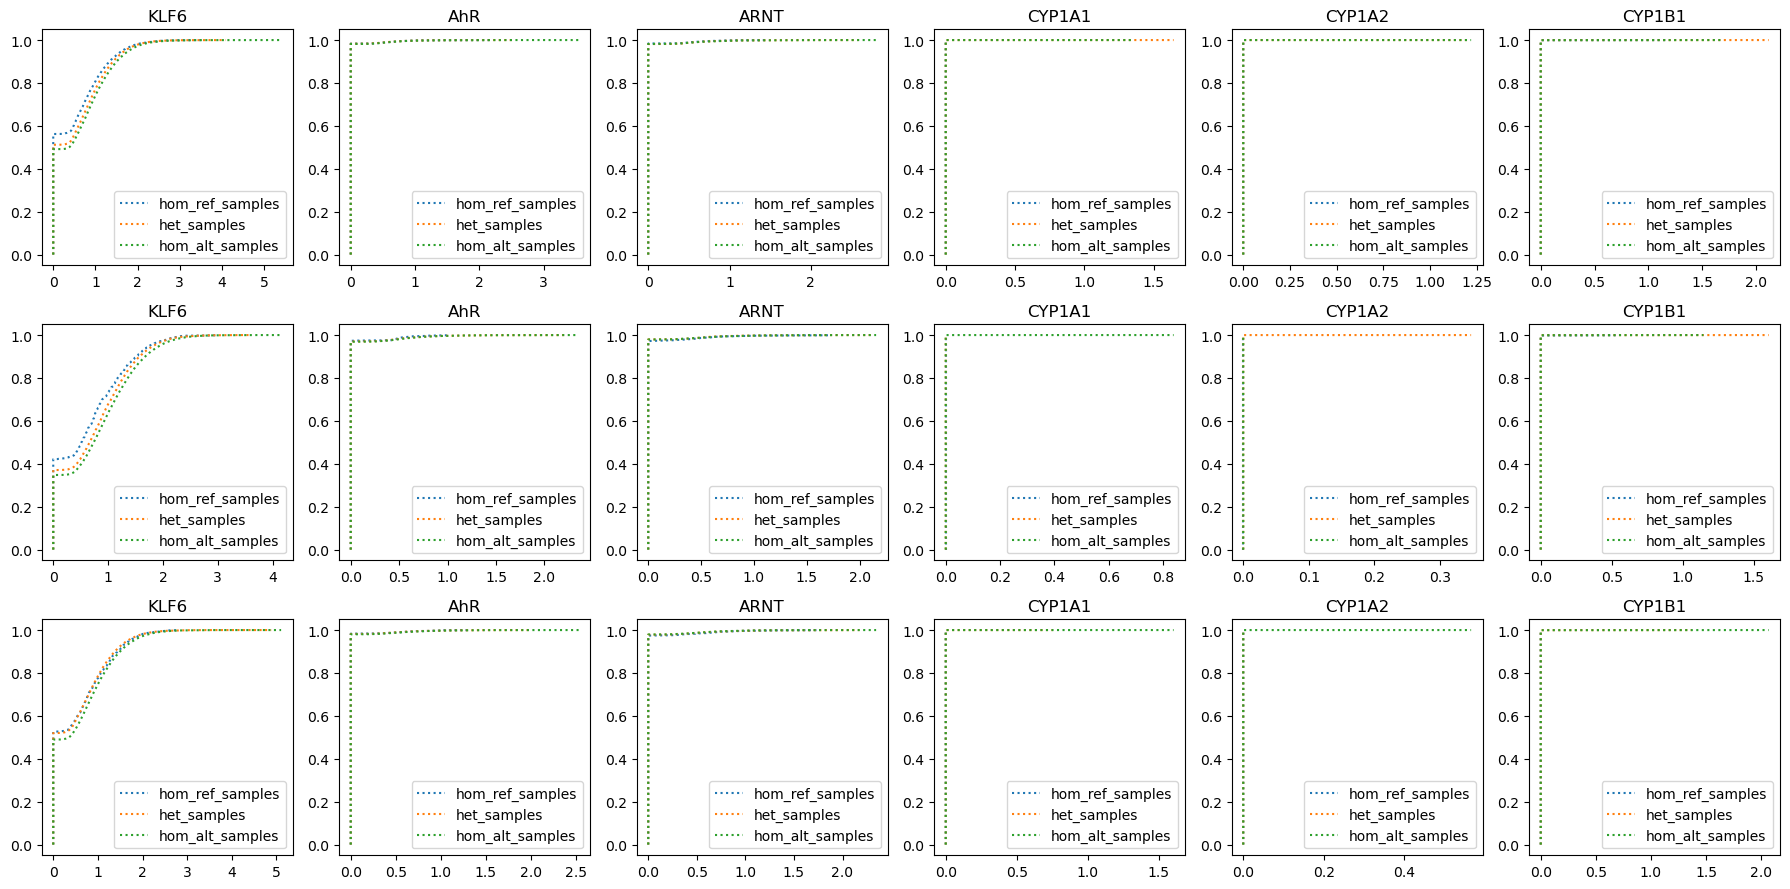

In [316]:
n_cell_types = eqtl[mask].shape[0]
n_genes = len(targets.keys())
fig, ax = plt.subplots(n_cell_types, n_genes)
fig.set_size_inches(3*n_genes, 3*n_cell_types)

for ax_y, cell_type in enumerate(eqtl.loc[mask, 'Cell type']):
    for ax_x, gene in enumerate(targets.keys()):
        axis = ax[ax_y][ax_x]
        expr_list = []
        class_list = []
        
        for col in range(len(colnames)):
            search_str = eqtl.loc[snps[0], colnames[col]] # Select the string with the right patients
            if type(search_str)!=str:
                continue
            search_str = search_str.replace(',', '|') # Transform to regex

            datamask = np.logical_and(data.obs.individual.str.contains(search_str, regex=True),
                                  data.obs['old_cell_label']==cell_type)

            x = data[datamask, targets[gene]].to_df().to_numpy().flatten()

            expr_list.append(x.flatten())
            class_list.extend([colnames[col] for i in range(x.shape[0])])
        
        for sample in range(len(expr_list)):
            cdf(expr_list[sample], colnames[sample], ax=axis)
        axis.legend()
        axis.set_title(gene)
plt.tight_layout()